In [1]:
%load_ext autoreload
%autoreload 2


In [33]:
#from flowField import *
from flowFieldWavy import *
import h5py
import numpy as np
import pdb
import cProfile
import time
import scipy as sp
#from pseudo import *
from scipy.optimize import least_squares
#from scipy.linalg import norm, svd
import scipy.sparse.linalg as spla
from scipy.sparse.linalg import gmres, LinearOperator
#from scipy.optimize import newton_krylov,root,anderson
import exactRiblet as rib
import os
import resource
import sys

import matplotlib.pyplot as plt
%matplotlib inline

#figureFolder = "/home/sabarish/Dropbox/reports/2016/equilibria/figures/"
symDir = '/home/sabarish/Dropbox/gitwork/python3/symmetries/'
#figureFolder = './figures/'
#docFolder = "./doc/figures/"
#%run test_flowFieldWavy.py
resnormFun = lambda x: x.residuals().appendField(x.slice(nd=[0,1,2]).div()).norm()

In [21]:
%run test_flowFieldWavy.py

..........

Note: when testing for derivatives, if looking at the last modes in x or z,remember that the general formulae I use do not apply, because one/some of their neighbouring modes are missing



----------------------------------------------------------------------
Ran 10 tests in 0.065s

OK


In [ ]:
%run test_flowFieldRiblet.py

In [35]:
x0 = loadh5('ribEq1_25_L7M16N35E1_001E2_000E3_030.hdf5').slice(L=2,M=4,N=15)
x0.setWallVel(); x0.imposeSymms(sigma1=True,sigma3=True)
x0.flowDict.update({'eps':0.,'epsArr':np.array([0.,0.])})
print(type(x0), isinstance(x0,flowFieldRiblet), x0.nd)

ffProb = rib.exactRiblet(x=x0, sigma1=False, sigma3=False)
rib.testExactRibletModule(ffProb)

ffProb.x.flowDict.update({'eps':0.05,'epsArr':np.array([0., 0.05])})
rib.testExactRibletModule(ffProb)

ffProb.attributes.update({'sigma1':True})
rib.testExactRibletModule(ffProb)

ffProb.attributes.update({'sigma3':True})
rib.testExactRibletModule(ffProb)

phiArr is not in flowDict. Using zeros.
<class 'flowFieldWavy.flowFieldRiblet'> True 4


AssertionError: 

## Profiling dogbox ('lsmr')

In [11]:
x = loadh5('testMethods/dogboxWithoutJac/ribEq1L5M6N25E1_030.hdf5')
#x = x.slice(L=3,M=5,N=20)
x.setWallVel()
x.imposeSymms()

print('Iterating for method: dogbox, no jac, lsmr, with sparsity')
startTime = time.time()
ffProb = rib.exactRiblet(x=x,sigma1=True,sigma3=True,iterMax=1,method='dogbox',supplyJac=False,\
                          jacSparsity=True, tr_solver='lsmr',log=None,saveDir=None)
%prun -s cumulative ffProb.iterate()
print('Memory use (MB):', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024)
print('runTime (min): %d' %((time.time()-startTime)/60.))


Iterating for method: dogbox, no jac, lsmr, with sparsity
Not using a log file, printing to terminal
Initial residual norm is 1.6e-07
Starting iterations...............
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.9535e-15                                    2.20e-05    
       1              5         2.6695e-15      3.28e-15       1.83e-10       7.85e-06    
The maximum number of function evaluations is exceeded.
Function evaluations 5, initial cost 5.9535e-15, final cost 2.6695e-15, first-order optimality 7.85e-06.
 Memory use (MB): 848.92578125
runTime (min): 8


In [6]:
x = loadh5('testMethods/dogboxWithoutJac/ribEq1L5M6N25E1_030.hdf5')
#x = x.slice(L=3,M=5,N=20)
x.setWallVel()
x.imposeSymms()

print('Iterating for method: dogbox, no jac, lsmr, without sparsity')
startTime = time.time()
ffProb = rib.exactRiblet(x=x,sigma1=True,sigma3=True,iterMax=1,method='dogbox',supplyJac=False,\
                          jacSparsity=False, tr_solver='lsmr',log=None,saveDir=None)
%prun -s cumulative ffProb.iterate()
print('Memory use (MB):', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024)
print('runTime (min): %d' %((time.time()-startTime)/60.))


Iterating for method: dogbox, no jac, lsmr, without sparsity
Not using a log file, printing to terminal
Initial residual norm is 1.6e-07
Starting iterations...............
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.9535e-15                                    2.20e-05    
       1              2         2.3064e-19      5.95e-15       7.94e-07       1.30e-07    
       2              3         7.1592e-20      1.59e-19       3.04e-08       7.25e-08    
       3              4         1.0767e-20      6.08e-20       1.44e-08       2.81e-08    
       4              5         4.6032e-21      6.16e-21       2.89e-08       1.84e-08    
The maximum number of function evaluations is exceeded.
Function evaluations 5, initial cost 5.9535e-15, final cost 4.6032e-21, first-order optimality 1.84e-08.
 Memory use (MB): 734.11328125
runTime (min): 20


In [7]:
x = loadh5('testMethods/dogboxWithoutJac/ribEq1L5M6N25E1_030.hdf5')
#x = x.slice(L=3,M=5,N=20)
x.setWallVel()
x.imposeSymms()

print('Iterating for method: simple')
startTime = time.time()
ffProb = rib.exactRiblet(x=x,sigma1=True,sigma3=True,iterMax=6,method='simple',supplyJac=False,\
                          jacSparsity=False, tr_solver='lsmr',log=None,saveDir=None)
%prun -s cumulative ffProb.iterate()
print('Memory use (MB):', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024)
print('runTime (min): %d' %((time.time()-startTime)/60.))


Iterating for method: simple
Not using a log file, printing to terminal
Initial residual norm is 1.6e-07
Starting iterations...............
iter: 1
Jacobian inversion returned with residual norm: []
Beginning line search.... Initial residual norm is  1.60436456321e-07
Minimal norm is obtained for q in q*dx of 25, producing norm of 4.84e-08
Minimal norm is obtained for q in q*dx of 25, producing norm of 4.84e-08
Residual norm after 1 th iteration is 4.84e-08
*********************************************************
iter: 2
Jacobian inversion returned with residual norm: []
Beginning line search.... Initial residual norm is  4.83639407895e-08
Minimal norm is obtained for q in q*dx of 9, producing norm of 1.67e-08
Minimal norm is obtained for q in q*dx of 9.1, producing norm of 1.67e-08
Residual norm after 2 th iteration is 1.67e-08
*********************************************************
iter: 3
Jacobian inversion returned with residual norm: []
Beginning line search.... Initial residua

In [6]:
x = loadh5('testMethods/dogboxWithoutJac/ribEq1L5M6N25E1_030.hdf5')
x = x.slice(L=14,M=16,N=35)
x.setWallVel()
x.imposeSymms()

%prun -s cumulative for k in range(100): x.residuals().appendField(x.div()).norm()

In [16]:
x = loadh5('testMethods/dogboxWithoutJac/ribEq1L5M6N25E1_030.hdf5')
#x = x.slice(L=3,M=5,N=20)
x.setWallVel()
x.imposeSymms()

print('Iterating for method: dogbox, no jac, exact')
startTime = time.time()
ffProb = rib.exactRiblet(x=x,sigma1=True,sigma3=True,iterMax=1,method='dogbox',supplyJac=False,\
                          tr_solver='exact',log=None,saveDir=None)
%prun -s cumulative ffProb.iterate()
print('Memory use (MB):', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024)
print('runTime (min): %d' %((time.time()-startTime)/60.))


Iterating for method: dogbox, no jac, exact
Not using a log file, printing to terminal
Initial residual norm is 1.6e-07
Starting iterations...............
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.9535e-15                                    2.20e-05    
       1              2         2.3064e-19      5.95e-15       7.94e-07       1.30e-07    
       2              3         7.1592e-20      1.59e-19       3.04e-08       7.25e-08    
       3              4         1.0767e-20      6.08e-20       1.44e-08       2.81e-08    
       4              5         4.6032e-21      6.16e-21       2.89e-08       1.84e-08    
The maximum number of function evaluations is exceeded.
Function evaluations 5, initial cost 5.9535e-15, final cost 4.6032e-21, first-order optimality 1.84e-08.
 Memory use (MB): 712.6484375
runTime (min): 20


In [18]:
x = loadh5('testMethods/dogboxWithoutJac/ribEq1L5M6N25E1_030.hdf5')
#x = x.slice(L=3,M=5,N=20)
x.setWallVel()
x.imposeSymms()

print('Iterating for method: dogbox, with jac, exact')
startTime = time.time()
ffProb = rib.exactRiblet(x=x,sigma1=True,sigma3=True,iterMax=4,method='dogbox',supplyJac=True,\
                          tr_solver='lsmr',log=None,saveDir=None)
%prun -s cumulative ffProb.iterate()
print('Memory use (MB):', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024)
print('runTime (min): %d' %((time.time()-startTime)/60.))


Iterating for method: dogbox, with jac, exact
Not using a log file, printing to terminal
Initial residual norm is 1.6e-07
Starting iterations...............
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.9535e-15                                    2.32e-05    
       1             16         3.5762e-15      2.38e-15       1.29e-09       7.20e-06    
       2             19         3.3746e-15      2.02e-16       5.04e-11       5.18e-06    
       3             20         3.2430e-15      1.32e-16       5.40e-11       3.22e-06    
The maximum number of function evaluations is exceeded.
Function evaluations 20, initial cost 5.9535e-15, final cost 3.2430e-15, first-order optimality 3.22e-06.
 Memory use (MB): 768.6484375
runTime (min): 3


# Implementing trust region methods

## Small state-vector: L,M,N = 3,5,15

In [5]:
x = loadh5('solutions/e1/A05/ribEq1L14M16N35E1_025.hdf5')
x.flowDict['eps'] = 0.03
x.flowDict['epsArr'] = np.array([0., 0.03])
x = x.slice(L=2,M=3,N=10) 
x[0,x.nx//2,x.nz//2,0,0] = 1.
x[0,x.nx//2,x.nz//2,0,-1] = -1.

flowDict = x.flowDict.copy()

In [10]:
print('Iterating for method: standard Newton')
startTime = time.time()
#ribRes2 = rib.iterate(vf = x.slice(nd=[0,1,2]), pf = x.getScalar(nd=3),trustRegion=False,sigma1=True,sigma2=False,iterMax=5)
ffProb1 = rib.exactRiblet(x=x,sigma1=True,sigma3=True,iterMax=4,method='simple',log=None,saveDir=None)
ribRes1 = ffProb1.iterate()
print('Memory use (MB):', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024)
print('runTime (min): %d' %((time.time()-startTime)/60.))
#x = ribRes1[0]

Iterating for method: standard Newton
Not using a log file, printing to terminal
Initial residual norm is 0.0156
Starting iterations...............
iter: 1
Jacobian inversion returned with residual norm: 2.18446332552e-07
Beginning line search.... Initial residual norm is  0.0156479289112
Line search.... normArr is [ 0.01984846  0.01900687  0.01816595  0.01732575  0.01648637  0.01564793
  0.01481058  0.01397453  0.01314003  0.0123074   0.01147709  0.01064966
  0.00982591  0.00900691  0.00819417  0.00738986  0.00659719  0.0058211
  0.00506943  0.00435511  0.00370018  0.00314245  0.00274242  0.0025753
  0.00268557  0.0030438 ]
Minimal norm is obtained for q in q*dx of 1.8, producing norm of 0.00258
Finer line search.... normArr is [ 0.00274242  0.00271404  0.00268808  0.00266463  0.00264374  0.00262548
  0.0026099   0.00259706  0.00258699  0.00257973  0.0025753   0.00257372
  0.00257499  0.00257912  0.00258607  0.00259585  0.0026084   0.00262371
  0.0026417   0.00266235]
Minimal norm is 

In [7]:
print('Iterating for method: dogbox, no jac, exact')
startTime = time.time()
ffProb1 = rib.exactRiblet(x=x,sigma1=True,sigma3=True,iterMax=1,method='dogbox',supplyJac=False,\
                          tr_solver='exact',log=None,saveDir=None)
ribRes1 = ffProb1.iterate()
print('Memory use (MB):', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024)
print('runTime (min): %d' %((time.time()-startTime)/60.))
#x = ribRes1[0]

Iterating for method: dogbox, no jac, exact
Not using a log file, printing to terminal
Initial residual norm is 0.0156
Starting iterations...............
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.0980e-05                                    5.40e-02    
       1              2         1.2879e-06      2.97e-05       3.05e-02       3.45e-02    
       2              3         7.1224e-07      5.76e-07       1.72e-02       3.00e-02    
       3              5         2.2190e-07      4.90e-07       3.32e-03       3.13e-03    
The maximum number of function evaluations is exceeded.
Function evaluations 5, initial cost 3.0980e-05, final cost 2.2190e-07, first-order optimality 3.13e-03.
Memory use (MB): 170.60546875
runTime (min): 1


In [6]:
print('Iterating for method: dogbox, no jac, lsmr')
startTime = time.time()
ffProb1 = rib.exactRiblet(x=x,sigma1=True,sigma3=True,iterMax=1,method='dogbox',supplyJac=False,\
                          tr_solver='lsmr',log=None,saveDir=None)
ribRes1 = ffProb1.iterate()
print('Memory use (MB):', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024)
print('runTime (min): %d' %((time.time()-startTime)/60.))
#x = ribRes1[0]

Iterating for method: dogbox, no jac, lsmr
Not using a log file, printing to terminal
Initial residual norm is 0.0156
Starting iterations...............
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.0980e-05                                    5.40e-02    
       1              2         1.3181e-06      2.97e-05       3.06e-02       3.51e-02    
       2              3         7.0383e-08      1.25e-06       2.36e-02       1.42e-03    
       3              5         5.3768e-08      1.66e-08       1.22e-02       2.73e-04    
The maximum number of function evaluations is exceeded.
Function evaluations 5, initial cost 3.0980e-05, final cost 5.3768e-08, first-order optimality 2.73e-04.
Memory use (MB): 173.03125
runTime (min): 1


In [8]:
print('Iterating for method: lm')
startTime = time.time()
ribRes2 = rib.iterate(vf = x.slice(nd=[0,1,2]), pf = x.getScalar(nd=3),method='lm',max_nfev=5000)
print('Memory use (MB):', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024)
print('runTime (min): %d' %((time.time()-startTime)/60.))

Iterating for method: lm
Initial residual norm is 0.00317
Starting iterations...............
The maximum number of function evaluations is exceeded.
Function evaluations 2402, initial cost 2.6894e-06, final cost 7.9778e-08, first-order optimality 1.63e-03.
Memory use (MB): 191.86328125
runTime (min): 5


In [ ]:
print('Iterating for method: dogbox with more nfev=500')
startTime = time.time()
ribRes2 = rib.iterate(vf = x.slice(nd=[0,1,2]), pf = x.getScalar(nd=3),method='dogbox',max_nfev=6, jac='2-point')
print('Memory use (MB):', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024)
print('runTime (min): %d' %((time.time()-startTime)/60.))
print('Memory use (MB):', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024)
print('runTime (min): %d' %((time.time()-startTime)/60.))

In [6]:
print('Memory use (MB):', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024)
print('runTime (min): %d' %((time.time()-startTime)/60.))

Memory use (MB): 282.8984375
runTime (min): 22


In [6]:
print('Iterating for method: lm with nfev=10000')
startTime = time.time()
ribRes2 = rib.iterate(vf = x.slice(nd=[0,1,2]), pf = x.getScalar(nd=3),method='lm',max_nfev=10000, jac='2-point')
print('Memory use (MB):', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024)
print('runTime (min): %d' %((time.time()-startTime)/60.))

Iterating for method: lm with nfev=10000
Initial residual norm is 0.00317
Starting iterations...............
The maximum number of function evaluations is exceeded.
Function evaluations 12013, initial cost 2.6894e-06, final cost 6.8827e-12, first-order optimality 1.34e-06.
Memory use (MB): 191.1484375
runTime (min): 13


In [7]:
# Comparing methods 'trf','dogbox', 'lm'
print('Iterating for method: trf with nfev=8')
startTime = time.time()
ribRes2 = rib.iterate(vf = x.slice(nd=[0,1,2]), pf = x.getScalar(nd=3),method='trf',max_nfev=8, jac='2-point')
print('Memory use (MB):', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024)
print('runTime (min): %d' %((time.time()-startTime)/60.))

Iterating for method: trf with nfev=8
Initial residual norm is 0.00317
Starting iterations...............
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.6894e-06                                    1.41e-02    
       1              2         6.9369e-11      2.69e-06       3.28e-03       1.06e-05    
       2              3         1.2616e-12      6.81e-11       1.72e-03       1.08e-06    
       3              4         9.4520e-13      3.16e-13       2.23e-03       5.37e-07    
       4              5         1.9429e-13      7.51e-13       8.43e-04       9.30e-08    
       5              7         1.9129e-13      3.00e-15       8.87e-04       1.03e-07    
       6              8         1.6839e-13      2.29e-14       2.22e-04       6.50e-09    
`gtol` termination condition is satisfied.
Function evaluations 8, initial cost 2.6894e-06, final cost 1.6839e-13, first-order optimality 6.50e-09.
Memory use (MB): 7

## Increased state-vector size: L,M,N = 5,6,25

In [ ]:
x = loadh5('solutions/e1/A05/ribEq1L14M16N35E1_025.hdf5')
x.flowDict['eps'] = 0.03
x.flowDict['epsArr'] = np.array([0., 0.03])
x = x.slice(L=5,M=6,N=25) 
x[0,x.nx//2,x.nz//2,0,0] = 1.
x[0,x.nx//2,x.nz//2,0,-1] = -1.

flowDict = x.flowDict.copy()

In [ ]:
print('Iterating for method: lm with nfev=100000')
startTime = time.time()
ribRes2 = rib.iterate(vf = x.slice(nd=[0,1,2]), pf = x.getScalar(nd=3),method='lm',max_nfev=100000, jac='2-point')
print('Memory use (MB):', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024)
print('runTime (min): %d' %((time.time()-startTime)/60.))

Iterating for method: lm with nfev=100000
Initial residual norm is 0.00121
Starting iterations...............


In [ ]:
# Comparing methods 'trf','dogbox', 'lm'
print('Iterating for method: trf with nfev=8')
startTime = time.time()
ribRes2 = rib.iterate(vf = x.slice(nd=[0,1,2]), pf = x.getScalar(nd=3),method='trf',max_nfev=8, jac='2-point')
print('Memory use (MB):', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024)
print('runTime (min): %d' %((time.time()-startTime)/60.))

In [ ]:
# Comparing methods 'trf','dogbox', 'lm'
print('Iterating for method: dogbox with nfev=8')
startTime = time.time()
ribRes2 = rib.iterate(vf = x.slice(nd=[0,1,2]), pf = x.getScalar(nd=3),method='dogbox',max_nfev=8, jac='2-point')
print('Memory use (MB):', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024)
print('runTime (min): %d' %((time.time()-startTime)/60.))

In [4]:
print('Iterating for method: standard Newton')
startTime = time.time()
ribRes2 = rib.iterate(vf = x.slice(nd=[0,1,2]), pf = x.getScalar(nd=3),trustRegion=False,sigma1=True,sigma2=True,iterMax=3)
print('Memory use (MB):', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024)
print('runTime (min): %d' %((time.time()-startTime)/60.))

Iterating for method: standard Newton
Initial residual norm is 0.00121
Starting iterations...............
iter: 1
Jacobian inversion returned with residual norm: 4.31075735127e-08
Beginning line search.... Initial residual norm is  0.00120552259161
Line search.... normArr is [ 0.00153139  0.00146575  0.0014003   0.00133509  0.00127015  0.00120552
  0.00114126  0.00107742  0.00101409  0.00095137  0.0008894   0.00082833
  0.00076838  0.00070985  0.0006531   0.00059865  0.00054718  0.00049961
  0.00045717  0.0004214   0.00039413  0.00037721  0.00037204  0.00037912
  0.00039778  0.00042652]
Minimal norm is obtained for q in q*dx of 1.7, producing norm of 0.000372
Finer line search.... normArr is [ 0.00037721  0.00037615  0.0003752   0.00037438  0.00037368  0.0003731
  0.00037264  0.00037231  0.0003721   0.00037201  0.00037204  0.0003722
  0.00037249  0.00037289  0.00037342  0.00037407  0.00037484  0.00037573
  0.00037674  0.00037787]
Minimal norm is obtained for q in q*dx of 1.7, producing

In [15]:
L = 10; M = 0; N=35
n1 = (L+1)*(M+1)*8; n2 = n1*N
arr1 = np.ones(((2*n1-1+(16*N-18)),n2),dtype=np.int8)
offsets1 = np.arange(-(n1-1)*N,  -7*N, N)
offsets2 = np.arange(8*N, (n1-1)*N, N)
offsets3 = np.arange(-8*N+1, 8*N-1)
offsets = np.concatenate((offsets1, offsets2, offsets3))
arr1.shape, offsets.shape

((717, 3080), (717,))

In [ ]:
# Using gmres to solve newton step
res0Arr = resFun(x.weighted())
jacFun = lambda dxArr: matVecFun(x.weighted(), res0Arr, dxArr)
jacMat = LinearOperator((x.size,x.size), matvec=jacFun,dtype=np.complex)

linResult = gmres(jacMat, -res0Arr)

In [ ]:
dx = weighted2ff(arr=linResult[0], flowDict=flowDict,weights=weights,cls='riblet').residuals().norm()
xNew = x.copy()
xNew[:] += dx

x.residuals().norm(), xNew.residuals().norm(), np.linalg.norm(jacMat.matvec(linResult[0])+ res0Arr)


In [ ]:
# Using lgmres to solve newton step
res0Arr = resFun(x.weighted())
jacFun = lambda dxArr: matVecFun(x.weighted(), res0Arr, dxArr)
jacMat = LinearOperator((x.size,x.size), matvec=jacFun,dtype=np.complex)

linResult = spla.lgmres(jacMat, -res0Arr)

In [ ]:
# Using spsolve to solve newton step
import laminar as lam


In [ ]:
x = x.slice(L=5,M=12)
vf = x.slice(nd=[0,1,2]); pf = x.getScalar(nd=3)

J, F = rib.makeSystem(vf=vf, pf=pf, sigma1=True, sigma2=True,realValued=False)
resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1000.


In [ ]:
sys.getsizeof(J)/1000./1000.

In [ ]:
#x = x.slice(L=3, M=5,N=20)
#vf = x.slice(nd=[0,1,2]); pf = x.getScalar(nd=3)
vf.flowDict['epsArr'] = np.array([0.,0.001,0.001])
pf.flowDict['epsArr'] = np.array([0.,0.001,0.001])
vf, pf, fnorm, flg = rib.iterate(vf=vf, pf=pf, iterMax=7, sigma1=True,sigma2=False,realValued=True)
resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1000.

In [ ]:
#x = x.slice(L=3, M=5,N=20)
#vf = x.slice(nd=[0,1,2]); pf = x.getScalar(nd=3)
vf.flowDict['epsArr'] = np.array([0.,0.001,0.003])
pf.flowDict['epsArr'] = np.array([0.,0.001,0.003])
vf, pf, fnorm, flg = rib.iterate(vf=vf, pf=pf, iterMax=10, sigma1=True,sigma2=False,realValued=True)
resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1000.

In [ ]:
#x = x.slice(L=3, M=5,N=20)
#vf = x.slice(nd=[0,1,2]); pf = x.getScalar(nd=3)
vf.flowDict['epsArr'] = np.array([0.,0.001,0.005])
pf.flowDict['epsArr'] = np.array([0.,0.001,0.005])
vf, pf, fnorm, flg = rib.iterate(vf=vf, pf=pf, iterMax=10, sigma1=True,sigma2=False,realValued=True)
resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1000.

In [ ]:
#x = x.slice(L=3, M=5,N=20)
#vf = x.slice(nd=[0,1,2]); pf = x.getScalar(nd=3)
vf.flowDict['epsArr'] = np.array([0.,0.001,0.007])
pf.flowDict['epsArr'] = np.array([0.,0.001,0.007])
vf, pf, fnorm, flg = rib.iterate(vf=vf, pf=pf, iterMax=10, sigma1=True,sigma2=False,realValued=True)
resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1000.

In [ ]:
#x = x.slice(L=3, M=5,N=20)
#vf = x.slice(nd=[0,1,2]); pf = x.getScalar(nd=3)
vf.flowDict['epsArr'] = np.array([0.,0.001,0.01])
pf.flowDict['epsArr'] = np.array([0.,0.001,0.01])
vf, pf, fnorm, flg = rib.iterate(vf=vf, pf=pf, iterMax=10, sigma1=True,sigma2=False,realValued=True)
resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1000.

In [ ]:
#x = x.slice(L=3, M=5,N=20)
#vf = x.slice(nd=[0,1,2]); pf = x.getScalar(nd=3)
vf.flowDict['epsArr'] = np.array([0.,0.001,0.015])
pf.flowDict['epsArr'] = np.array([0.,0.001,0.015])
vf, pf, fnorm, flg = rib.iterate(vf=vf, pf=pf, iterMax=10, sigma1=True,sigma2=False,realValued=True)
resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1000.

In [ ]:
# Test solver for eps1 with sigma1=sigma2=True, realValued=False
vf = x.slice(nd=[0,1,2]); pf = x.getScalar(nd=3)
vf, pf, fnorm, flg = rib.iterate(vf=vf, pf=pf, iterMax=7, sigma1=True,sigma2=True,realValued=False)


In [ ]:
[0.0043027822607007845, 0.0011592846998231703, 0.00021116635545736966, 2.60516643408694e-05, 3.9210300290258834e-06, 5.7135847893508423e-07, 1.0446310161841565e-07]

In [ ]:
x = x.slice(L=2,M=4,N=16)
vf = x.slice(nd=[0,1,2]); pf = x.getScalar(nd=3)
J0,F0 = rib.makeSystem(vf = vf, pf=pf, sigma1=True, sigma2=False)
J1,F1 = rib.makeSystem(vf = vf, pf=pf, sigma1=True, sigma2=True)
dx0, linNorm0, jRank0,sVals0 = np.linalg.lstsq(J0,-F0,rcond=1.0e-06)
dx1, linNorm1, jRank1,sVals1 = np.linalg.lstsq(J1,-F1,rcond=1.0e-06)

In [ ]:
dx00 = dx0.reshape((5,5,4,16))
dx10 = dx1.reshape((3,5,4,16))

In [ ]:
chebnorm((dx10 - dx00[:3]), x.N), chebnorm(dx0,x.N), chebnorm(dx1,x.N)

In [ ]:
compArr = np.array([-1.,-1.,1.,1.]).reshape((1,1,4,1))
lArr = np.arange(-2,0).reshape((2,1,1,1))
mArr = np.arange(-4,1).reshape((1,5,1,1))
diff = dx10[:2] - (-1.)**(lArr + mArr) * compArr * dx00[:2:-1,:,:,::-1]


In [ ]:
dxff = x.zero()
dxff[0,:,:5] = dx00
lArr = np.arange(-2.,3.).reshape((5,1,1,1)); mArr = np.arange(-4.,0.).reshape((1,4,1,1))
compArr = np.array([1.,1.,-1.,1.]).reshape((1,1,4,1))
dxff[0,:,:4:-1] = (-1.)**lArr * compArr * dxff[0,:,:4]
chebnorm(diff, x.N), dxff.checkSymms()

In [ ]:
chebnorm(np.dot(J0,dx0)+F0, x.N), chebnorm(np.dot(J1,dx1)+F1, x.N)

In [ ]:
x = x.slice(L=2,M=4,N=16)
vf = x.slice(nd=[0,1,2]); pf = x.getScalar(nd=3)
J0,F0 = rib.makeSystem(vf = vf, pf=pf, sigma1=False, sigma2=False)
Jsize = J0.shape[0]
J1 = J0[: np.int(0.6*Jsize)]
F1 = F0[: np.int(0.6*Jsize)]
dx0, linNorm0, jRank0,sVals0 = np.linalg.lstsq(J0,-F0,rcond=1.0e-06)
dx1, linNorm1, jRank1,sVals1 = np.linalg.lstsq(J1,-F1,rcond=1.0e-06)

In [ ]:
dx11 = dx1.reshape((5,9,4,16))
dx00 = dx0.reshape((5,9,4,16))
chebnorm(dx11 - np.conjugate(dx11[::-1, ::-1]), x.N), chebnorm(dx00 - np.conjugate(dx00[::-1, ::-1]), x.N), chebnorm(dx1-dx0, x.N)

# Validating solver with laminar flows

In [ ]:
flowDict = getDefaultDict()
flowDict.update({'L':1, 'M':6,'N':30,'alpha':5.,'beta':10.,'eps':0.05,'epsArr':np.array([0.,0.05]),'Re':100.,'isPois':0})

start = time.time()
vf = flowFieldRiblet(flowDict=flowDict).view4d()
vf[0,vf.nx//2,vf.nz//2,0] = vf.y
pf = vf.getScalar().zero()

vf, pf, fnorm, flg = rib.iterate(vf=vf, pf=pf,doLineSearch=False,rcond=1.0e-07)
print('runTime(s):',time.time()-start)
vf0 = vf.copy(); pf0 = pf.copy()

# Plots for JFMrapids

## Residual norms, accuracy, energy density, bulk dissipation rate

In [ ]:
#%%%%%%%%%%%%%%%%%%%%
# eps_1

#%%%%%%%%%%%%%%%%%%%%%%%%
loadPath='solutions/e1/'
nSol = 21 # Number of solutions
x0 = loadh5('ribEq1L7M10N30E0000.hdf5').slice(L=7,M=16,N=35) # Initial iterate: Sol for flat-walled Couette

# Scalars to be plotted:
resnormArr = np.zeros(nSol)   # Residual norm of converged solutions
accArr = np.zeros(nSol)       # Accuracy of solutions w.r.t grid size
distArr = np.zeros(nSol)      # Distance from x0
energyArr = np.zeros(nSol)    # Energy density
dissipationArr = np.zeros(nSol) # Bulk dissipation rate
pInputArr = np.zeros(nSol)      # 
initialnormArr = np.zeros(nSol)
epsArr = np.zeros(nSol)

resnormArr[0] = resnormFun(x0.slice(M=16,N=30))
accArr[0]  = resnormFun(x0.slice(L=14,M=20,N=60))
distArr[0] = 0.
energyArr[0] = x0.energy(); dissipationArr[0] = x0.dissipation(); pInputArr[0] = x0.powerInput()
initialnormArr[0] = resnormArr[0]
for k in range(1,nSol):
    solPath = loadPath+'A%02d/'%(k)
    solName = 'ribEq1L7M16N35E1_%03d.hdf5'%(5*k)
    x = loadh5(solPath+solName)
    epsArr[k] = x.flowDict['epsArr'][1]
    resnormArr[k] = resnormFun(x)
    accArr[k] = resnormFun(x.slice(L=14,M=32,N=70))
    distArr[k] = (x-x0).norm()
    
    energyArr[k] = x.energy()
    dissipationArr[k] = x.dissipation()
    pInputArr[k] = x.powerInput()
    
    x[:] = x0[:]
    initialnormArr[k] = resnormFun(x)
    

In [ ]:
figureFolder = './figures/'
# Residual norm, accuracy, and distance
fig,ax1 = plt.subplots()
ln1 = ax1.plot(2.*epsArr, resnormArr,'bx',label='Residual norm')
ln2 = ax1.plot(2.*epsArr, accArr,'b+',label='Accuracy')
ax1.set_ylabel('$||F(\\chi^*)||$',color='b',fontsize=15)
ax1.set_xlim([-0.01,0.21])
ax1.set_yscale('log')
ax1.set_ylim([1.0e-10,0.1])

ax2 = ax1.twinx()
ln3 = ax2.plot(2.*epsArr, distArr,'r*:',label='Distance')
ln4 = ax2.plot(2.*epsArr, initialnormArr, 'rd:',label='Initial residual norm')
ax2.set_xlim([-0.01,0.21])
ax2.set_ylim([0.,0.12])
ax2.set_ylabel('$||\chi^*-\chi^0||$',color='r',fontsize=15)

for tl in ax1.get_yticklabels():
    tl.set_color('b')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

line1,label1 = ax1.get_legend_handles_labels()
line2,label2 = ax2.get_legend_handles_labels()
ax2.legend(line1+line2, label1+label2,loc='upper center',ncol=2)

ax1.set_xlabel('Amplitude($A$)',fontsize=15)
plt.tight_layout()
plt.savefig(figureFolder+'normDistE1.eps',format='eps',dpi=1200)
plt.show()





# Energy density and bulk dissipation rate
fig,ax1 = plt.subplots()
ln1 = ax1.plot(2.*epsArr, energyArr,'bx:',label='Energy Density')
ax1.set_ylabel('E',color='b',fontsize=15)
ax1.set_xlim([-0.01,0.21])
ax1.set_ylim([0.1,0.15])
ax2 = ax1.twinx()
ln2 = ax2.plot(2.*epsArr, dissipationArr,'r+:',label='Dissipation rate ')
ax2.set_xlim([-0.01,0.21])
ax2.set_ylabel('D',color='r',fontsize=15)

for tl in ax1.get_yticklabels():
    tl.set_color('b')
for tl in ax2.get_yticklabels():
    tl.set_color('r')


line1,label1 = ax1.get_legend_handles_labels()
line2,label2 = ax2.get_legend_handles_labels()
ax2.legend(line1+line2, label1+label2,loc=4)

ax1.set_xlabel('Amplitude($A$)',fontsize=15)
plt.tight_layout()
plt.savefig(figureFolder+'energyDissipationE1.eps',format='eps',dpi=1200)
plt.show()


In [ ]:
#%%%%%%%%%%%%%%%%%%%%
# eps_2

#%%%%%%%%%%%%%%%%%%%%%%%%
loadPath='solutions/e2/'
nSol = 11 # Number of solutions
x0 = loadh5('ribEq1L7M10N30E0000.hdf5').slice(L=7,M=16,N=35) # Initial iterate: Sol for flat-walled Couette

# Scalars to be plotted:
resnormArr = np.zeros(nSol)   # Residual norm of converged solutions
accArr = np.zeros(nSol)       # Accuracy of solutions w.r.t grid size
distArr = np.zeros(nSol)      # Distance from x0
energyArr = np.zeros(nSol)    # Energy density
dissipationArr = np.zeros(nSol) # Bulk dissipation rate
pInputArr = np.zeros(nSol)      # 
initialnormArr = np.zeros(nSol)
epsArr = np.zeros(nSol)

resnormArr[0] = resnormFun(x0.slice(M=16,N=30))
accArr[0]  = resnormFun(x0.slice(L=14,M=20,N=60))
distArr[0] = 0.
energyArr[0] = x0.energy(); dissipationArr[0] = x0.dissipation(); pInputArr[0] = x0.powerInput()
initialnormArr[0] = resnormArr[0]
for k in range(1,nSol):
    solPath = loadPath+'A%02d/'%(k)
    solName = 'ribEq1L7M16N35E1_001E2_%03d.hdf5'%(5*k)
    x = loadh5(solPath+solName)
    epsArr[k] = x.flowDict['epsArr'][2]
    resnormArr[k] = resnormFun(x)
    accArr[k] = resnormFun(x.slice(L=14,M=32,N=70))
    distArr[k] = (x-x0).norm()
    
    energyArr[k] = x.energy()
    dissipationArr[k] = x.dissipation()
    pInputArr[k] = x.powerInput()
    
    x[:] = x0[:]
    initialnormArr[k] = resnormFun(x)
    

In [ ]:
figureFolder = './figures/'
# Residual norm, accuracy, and distance
fig,ax1 = plt.subplots()
ln1 = ax1.plot(2.*epsArr, resnormArr,'bx',label='Residual norm')
ln2 = ax1.plot(2.*epsArr, accArr,'b+',label='Accuracy')
ax1.set_ylabel('$||F(\\chi^*)||$',color='b',fontsize=15)
ax1.set_xlim([-0.01,0.11])
ax1.set_yscale('log')
ax1.set_ylim([1.0e-10,0.1])

ax2 = ax1.twinx()
ln3 = ax2.plot(2.*epsArr, distArr,'r*:',label='Distance')
ln4 = ax2.plot(2.*epsArr, initialnormArr, 'rd:',label='Initial residual norm')
ax2.set_xlim([-0.01,0.11])
ax2.set_ylim([0.,0.12])
ax2.set_ylabel('$||\chi^*-\chi^0||$',color='r',fontsize=15)

for tl in ax1.get_yticklabels():
    tl.set_color('b')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

line1,label1 = ax1.get_legend_handles_labels()
line2,label2 = ax2.get_legend_handles_labels()
ax2.legend(line1+line2, label1+label2,loc='upper center',ncol=2)

ax1.set_xlabel('Amplitude($A$)',fontsize=15)
plt.tight_layout()
plt.savefig(figureFolder+'normDistE2.eps',format='eps',dpi=1200)
plt.show()





# Energy density and bulk dissipation rate
fig,ax1 = plt.subplots()
ln1 = ax1.plot(2.*epsArr, energyArr,'bx:',label='Energy Density')
ax1.set_ylabel('E',color='b',fontsize=15)
ax1.set_xlim([-0.01,0.11])
ax1.set_ylim([0.1,0.15])
ax2 = ax1.twinx()
ln2 = ax2.plot(2.*epsArr, dissipationArr,'r+:',label='Dissipation rate ')
ax2.set_xlim([-0.01,0.11])
ax2.set_ylim([1.42,1.55])
ax2.set_ylabel('D',color='r',fontsize=15)

for tl in ax1.get_yticklabels():
    tl.set_color('b')
for tl in ax2.get_yticklabels():
    tl.set_color('r')


line1,label1 = ax1.get_legend_handles_labels()
line2,label2 = ax2.get_legend_handles_labels()
ax2.legend(line1+line2, label1+label2,loc=4)

ax1.set_xlabel('Amplitude($A$)',fontsize=15)
plt.tight_layout()
plt.savefig(figureFolder+'energyDissipationE2.eps',format='eps',dpi=1200)
plt.show()


In [ ]:
#%%%%%%%%%%%%%%%%%%%%
# eps_3

#%%%%%%%%%%%%%%%%%%%%%%%%
loadPath='solutions/e3/'
nSol = 11 # Number of solutions
x0 = loadh5('ribEq1L7M10N30E0000.hdf5').slice(L=7,M=16,N=35) # Initial iterate: Sol for flat-walled Couette

# Scalars to be plotted:
resnormArr = np.zeros(nSol)   # Residual norm of converged solutions
accArr = np.zeros(nSol)       # Accuracy of solutions w.r.t grid size
distArr = np.zeros(nSol)      # Distance from x0
energyArr = np.zeros(nSol)    # Energy density
dissipationArr = np.zeros(nSol) # Bulk dissipation rate
pInputArr = np.zeros(nSol)      # 
initialnormArr = np.zeros(nSol)
epsArr = np.zeros(nSol)

resnormArr[0] = resnormFun(x0.slice(M=16,N=30))
accArr[0]  = resnormFun(x0.slice(L=14,M=20,N=60))
distArr[0] = 0.
energyArr[0] = x0.energy(); dissipationArr[0] = x0.dissipation(); pInputArr[0] = x0.powerInput()
initialnormArr[0] = resnormArr[0]
for k in range(1,nSol):
    solPath = loadPath+'A%02d/'%(k)
    solName = 'ribEq1L7M16N35E1_001E2_000E3_%03d.hdf5'%(5*k)
    x = loadh5(solPath+solName)
    epsArr[k] = x.flowDict['epsArr'][3]
    resnormArr[k] = resnormFun(x)
    accArr[k] = resnormFun(x.slice(L=14,M=32,N=70))
    distArr[k] = (x-x0).norm()
    
    energyArr[k] = x.energy()
    dissipationArr[k] = x.dissipation()
    pInputArr[k] = x.powerInput()
    
    x[:] = x0[:]
    initialnormArr[k] = resnormFun(x)
    

In [ ]:
figureFolder = './figures/'
# Residual norm, accuracy, and distance
fig,ax1 = plt.subplots()
ln1 = ax1.plot(2.*epsArr, resnormArr,'bx',label='Residual norm')
ln2 = ax1.plot(2.*epsArr, accArr,'b+',label='Accuracy')
ax1.set_ylabel('$||F(\\chi^*)||$',color='b',fontsize=15)
ax1.set_xlim([-0.01,0.11])
ax1.set_yscale('log')
ax1.set_ylim([1.0e-10,0.1])

ax2 = ax1.twinx()
ln3 = ax2.plot(2.*epsArr, distArr,'r*:',label='Distance')
ln4 = ax2.plot(2.*epsArr, initialnormArr, 'rd:',label='Initial residual norm')
ax2.set_xlim([-0.01,0.11])
ax2.set_ylim([0.,0.12])
ax2.set_ylabel('$||\chi^*-\chi^0||$',color='r',fontsize=15)

for tl in ax1.get_yticklabels():
    tl.set_color('b')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

line1,label1 = ax1.get_legend_handles_labels()
line2,label2 = ax2.get_legend_handles_labels()
ax2.legend(line1+line2, label1+label2,loc='upper center',ncol=2)

ax1.set_xlabel('Amplitude($A$)',fontsize=15)
plt.tight_layout()
plt.savefig(figureFolder+'normDistE3.eps',format='eps',dpi=1200)
plt.show()





# Energy density and bulk dissipation rate
fig,ax1 = plt.subplots()
ln1 = ax1.plot(2.*epsArr, energyArr,'bx:',label='Energy Density')
ax1.set_ylabel('E',color='b',fontsize=15)
ax1.set_xlim([-0.01,0.11])
ax1.set_ylim([0.1,0.15])
ax2 = ax1.twinx()
ln2 = ax2.plot(2.*epsArr, dissipationArr,'r+:',label='Dissipation rate ')
ax2.set_xlim([-0.01,0.11])
ax2.set_ylim([1.42,1.55])
ax2.set_ylabel('D',color='r',fontsize=15)

for tl in ax1.get_yticklabels():
    tl.set_color('b')
for tl in ax2.get_yticklabels():
    tl.set_color('r')


line1,label1 = ax1.get_legend_handles_labels()
line2,label2 = ax2.get_legend_handles_labels()
ax2.legend(line1+line2, label1+label2,loc=4)

ax1.set_xlabel('Amplitude($A$)',fontsize=15)
plt.tight_layout()
plt.savefig(figureFolder+'energyDissipationE3.eps',format='eps',dpi=1200)
plt.show()


In [ ]:
figureFolder = './figures/'
#%%%%%%%%%%%%%%%%%%%%
# eps_3

#%%%%%%%%%%%%%%%%%%%%%%%%
loadPath='solutions/'
nSol = 11 # Number of solutions
x0 = loadh5('ribEq1L7M10N30E0000.hdf5').slice(L=7,M=16,N=35) # Initial iterate: Sol for flat-walled Couette

# Scalars to be plotted:
resnormArr = np.zeros((3,nSol))   # Residual norm of converged solutions
accArr = np.zeros((3,nSol))       # Accuracy of solutions w.r.t grid size
distArr = np.zeros((3,nSol))      # Distance from x0
energyArr = np.zeros((3,nSol))    # Energy density
dissipationArr = np.zeros((3,nSol)) # Bulk dissipation rate
pInputArr = np.zeros((3,nSol))      # 
initialnormArr = np.zeros((3,nSol))
epsArr = np.zeros((3,nSol))

resnormArr[:,0] = resnormFun(x0.slice(M=16,N=30))
accArr[:,0]  = resnormFun(x0.slice(L=14,M=20,N=60))
distArr[:,0] = 0.
energyArr[:,0] = x0.energy(); dissipationArr[:,0] = x0.dissipation(); pInputArr[:,0] = x0.powerInput()
#initialnormArr[:,0] = resnormArr[0]
for k in range(1,nSol):
    # eps_1
    solPath = loadPath+'e1/'+ 'A%02d/'%(k)
    solName = 'ribEq1L7M16N35E1_%03d.hdf5'%(5*k)
    x = loadh5(solPath+solName)
    epsArr[0,k] = x.flowDict['epsArr'][1]
    resnormArr[0,k] = resnormFun(x)
    accArr[0,k] = resnormFun(x.slice(L=14,M=32,N=70))
    distArr[0,k] = (x-x0).norm()
    
    energyArr[0,k] = x.energy()
    dissipationArr[0,k] = x.dissipation()
    pInputArr[0,k] = x.powerInput()
    
    x[:] = x0[:]
    initialnormArr[0,k] = resnormFun(x)
    
    # eps_2
    solPath = loadPath+'e2/'+ 'A%02d/'%(k)
    solName = 'ribEq1L7M16N35E1_001E2_%03d.hdf5'%(5*k)
    x = loadh5(solPath+solName)
    epsArr[1,k] = x.flowDict['epsArr'][2]
    resnormArr[1,k] = resnormFun(x)
    accArr[1,k] = resnormFun(x.slice(L=14,M=32,N=70))
    distArr[1,k] = (x-x0).norm()
    
    energyArr[1,k] = x.energy()
    dissipationArr[1,k] = x.dissipation()
    pInputArr[1,k] = x.powerInput()
    
    x[:] = x0[:]
    initialnormArr[1,k] = resnormFun(x)

    # eps_3
    solPath = loadPath+'e3/'+ 'A%02d/'%(k)
    solName = 'ribEq1L7M16N35E1_001E2_000E3_%03d.hdf5'%(5*k)
    x = loadh5(solPath+solName)
    epsArr[2,k] = x.flowDict['epsArr'][3]
    resnormArr[2,k] = resnormFun(x)
    accArr[2,k] = resnormFun(x.slice(L=14,M=32,N=70))
    distArr[2,k] = (x-x0).norm()
    
    energyArr[2,k] = x.energy()
    dissipationArr[2,k] = x.dissipation()
    pInputArr[2,k] = x.powerInput()
    
    x[:] = x0[:]
    initialnormArr[2,k] = resnormFun(x)
    


In [ ]:
# Residual norm, accuracy, and distance
plt.figure()
plt.plot(2.*epsArr[0], distArr[0],'rx-')
plt.plot(2.*epsArr[1], distArr[1],'b+:')
plt.plot(2.*epsArr[2], distArr[2],'kd--')
plt.legend(['$A_1$', '$A_2$', '$A_3$'], loc=2)
plt.xlabel('Amplitude ($A$)',fontsize=15); plt.ylabel('$||x-x_{flat}||$', fontsize=15)
plt.ylim([-0.01,0.075]); plt.xlim([-0.01,0.11])
plt.savefig(figureFolder+'normDistE123.eps',format='eps',dpi=1200)
plt.show()

# Energy density and bulk dissipation rate
plt.figure()
plt.plot(2.*epsArr[0], energyArr[0],'rx:',label='$A_1$')
plt.plot(2.*epsArr[1], energyArr[1],'b+:',label='$A_2$')
plt.plot(2.*epsArr[2], energyArr[2],'kd:',label='$A_3$')
plt.xlim([-0.01,0.11])
plt.ylim([0.13,0.15])
plt.legend(loc=2)
plt.xlabel('Amplitude($A$)',fontsize=15); plt.ylabel('Energy density ($E$)',fontsize=15)
plt.tight_layout()
plt.savefig(figureFolder+'energyE123.eps',format='eps',dpi=1200)
plt.show()

plt.figure()
plt.plot(2.*epsArr[0], dissipationArr[0],'rx:',label='$A_1$')
plt.plot(2.*epsArr[1], dissipationArr[1],'b+:',label='$A_2$')
plt.plot(2.*epsArr[2], dissipationArr[2],'kd:',label='$A_3$')
plt.xlim([-0.01,0.11])
plt.legend(loc=2)
plt.xlabel('Amplitude($A$)',fontsize=15); plt.ylabel('Dissipation rate ($D$)',fontsize=15)
plt.tight_layout()
plt.savefig(figureFolder+'dissipationE123.eps',format='eps',dpi=1200)
plt.show()


## Phase-difference

In [ ]:
# eps_1 = 0
x0 = loadh5('ribEq1L7M10N30E0000.hdf5')
x = x0
phaseArrZ = 2.*np.pi*np.arange(0.,1.001,0.05)

normArr = np.zeros(phaseArrZ.size)
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArr[m] = resnormFun(x.shiftPhase(phiZ=phiZ))
        
normArrA01 = np.zeros(phaseArrZ.size)
x = loadh5('solutions/e1/A01/ribEq1L7M16N35E1_005.hdf5')
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArrA01[m] = resnormFun(x.shiftPhase(phiZ=phiZ))
        
        
normArrA05 = np.zeros(phaseArrZ.size)
x = loadh5('solutions/e1/A05/ribEq1L7M16N35E1_025.hdf5')
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArrA05[m] = resnormFun(x.shiftPhase(phiZ=phiZ))
        



In [ ]:
plt.plot(phaseArrZ/np.pi/2., normArr)
plt.plot(phaseArrZ/np.pi/2., normArrA01,'r')
plt.plot(phaseArrZ/np.pi/2., normArrA05,'k')
plt.ylim([-0.002,0.015])
plt.legend(['A=0','A=0.01','A=0.05'])
plt.xlabel("$\delta z/L_z$",fontsize=15)
plt.ylabel("$F(\chi)$",fontsize=15)
#plt.yscale("log")
plt.savefig(figureFolder+'phaseShiftE1.eps',format='eps',dpi=1200)
plt.show()

In [ ]:
#%%%%%%%%%%%%%%%
# eps_2
#%%%%%%%%%%%%%%%%
# eps_q = 0
x0 = loadh5('ribEq1L7M10N30E0000.hdf5')
x = x0
phaseArrZ = 2.*np.pi*np.arange(0.,1.001,0.05)

normArr = np.zeros(phaseArrZ.size)
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArr[m] = resnormFun(x.shiftPhase(phiZ=phiZ))
        
normArrA01 = np.zeros(phaseArrZ.size)
x = loadh5('solutions/e2/A01/ribEq1L7M16N35E1_001E2_005.hdf5')
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArrA01[m] = resnormFun(x.shiftPhase(phiZ=phiZ))
        
        
normArrA05 = np.zeros(phaseArrZ.size)
x = loadh5('solutions/e2/A05/ribEq1L7M16N35E1_001E2_025.hdf5')
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArrA05[m] = resnormFun(x.shiftPhase(phiZ=phiZ))    


In [ ]:
plt.plot(phaseArrZ/np.pi/2., normArr)
plt.plot(phaseArrZ/np.pi/2., normArrA01,'r')
plt.plot(phaseArrZ/np.pi/2., normArrA05,'k')
#plt.ylim([-0.002,0.015])
plt.legend(['A=0','A=0.01','A=0.05'])
plt.xlabel("$\delta z/L_z$",fontsize=15)
plt.ylabel("$F(\chi)$",fontsize=15)
#plt.yscale("log")
plt.savefig(figureFolder+'phaseShiftE2.eps',format='eps',dpi=1200)
plt.show()

In [ ]:
#%%%%%%%%%%%%%%%
# eps_3
#%%%%%%%%%%%%%%%%
# eps_q = 0
x0 = loadh5('ribEq1L7M10N30E0000.hdf5')
x = x0
phaseArrZ = 2.*np.pi*np.arange(0.,1.001,0.05)

normArr = np.zeros(phaseArrZ.size)
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArr[m] = resnormFun(x.shiftPhase(phiZ=phiZ))
        
normArrA01 = np.zeros(phaseArrZ.size)
x = loadh5('solutions/e3/A01/ribEq1L7M16N35E1_001E2_000E3_005.hdf5')
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArrA01[m] = resnormFun(x.shiftPhase(phiZ=phiZ))
        
        
normArrA05 = np.zeros(phaseArrZ.size)
x = loadh5('solutions/e3/A05/ribEq1L7M16N35E1_001E2_000E3_025.hdf5')
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArrA05[m] = resnormFun(x.shiftPhase(phiZ=phiZ))
        



In [ ]:
plt.plot(phaseArrZ/np.pi/2., normArr)
plt.plot(phaseArrZ/np.pi/2., normArrA01,'r')
plt.plot(phaseArrZ/np.pi/2., normArrA05,'k')
#plt.ylim([-0.002,0.015])
plt.legend(['A=0','A=0.01','A=0.05'])
plt.xlabel("$\delta z/L_z$",fontsize=15)
plt.ylabel("$F(\chi)$",fontsize=15)
#plt.yscale("log")
plt.savefig(figureFolder+'phaseShiftE3.eps',format='eps',dpi=1200)
plt.show()

In [ ]:
#%%%%%%%%%%%%%%%
# eps_1, eps_2, eps_3
#%%%%%%%%%%%%%%%%
# eps_q = 0
x0 = loadh5('ribEq1L7M10N30E0000.hdf5')
x = x0
phaseArrZ = 2.*np.pi*np.arange(0.,1.001,0.025)

normArr = np.zeros(phaseArrZ.size)
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArr[m] = resnormFun(x.shiftPhase(phiZ=phiZ))

normArrE1 = np.zeros(phaseArrZ.size)
x = loadh5('solutions/e1/A01/ribEq1L7M16N35E1_005.hdf5')
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArrE1[m] = resnormFun(x.shiftPhase(phiZ=phiZ))

normArrE2 = np.zeros(phaseArrZ.size)
x = loadh5('solutions/e2/A01/ribEq1L7M16N35E1_001E2_005.hdf5')
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArrE2[m] = resnormFun(x.shiftPhase(phiZ=phiZ))

    
    
normArrE3 = np.zeros(phaseArrZ.size)
x = loadh5('solutions/e3/A01/ribEq1L7M16N35E1_001E2_000E3_005.hdf5')
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArrE3[m] = resnormFun(x.shiftPhase(phiZ=phiZ))
        


In [ ]:
plt.plot(phaseArrZ/np.pi/2., normArr)
plt.plot(phaseArrZ/np.pi/2., normArrE1,'r')
plt.plot(phaseArrZ/np.pi/2., normArrE2,'c')
plt.plot(phaseArrZ/np.pi/2., normArrE3,'k')
#plt.ylim([-0.002,0.015])
plt.legend(['flat','$A_1=0.01$','$A_2=0.01$', '$A_3=0.01$'],ncol=2,loc='upper center')
plt.xlabel("$\delta z/L_z$",fontsize=15)
plt.ylabel("$||F(\\chi)||$",fontsize=15)
plt.ylim([-0.002,0.012])
plt.savefig(figureFolder+'phaseShiftE123.eps',format='eps',dpi=1200)
plt.show()

## Velocity plots

In [ ]:
loadPath = 'solutions/e1/'
xList = [x0]
xList.append(loadh5(loadPath+'A05/ribEq1L7M16N35E1_025.hdf5'))
xList.append(loadh5(loadPath+'A10/ribEq1L7M16N35E1_050.hdf5'))
xList.append(loadh5(loadPath+'A15/ribEq1L7M16N35E1_075.hdf5'))
fNameList = ['A00','A05','A10','A15']
for k in range(len(xList)):    
    x = xList[k]
    fName = fNameList[k]
    vf = x.slice(nd=[0,1,2])
    pf = x.getScalar(nd=3)
    fnorm = x.residuals().appendField(x.div()).norm()

    b = vf.flowDict['beta']; Lz = 2.*np.pi/b; eps = vf.flowDict['eps']; A = 2.*eps
    a = vf.flowDict['alpha']; Lx = 2.*np.pi/a
    zArr = np.arange(0., Lz*1.001,Lz/20.)
    yArr = vf.y
    xArr = np.array([0., Lx/4.,Lx/2.])

    u = vf.getScalar().getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))
    v = vf.getScalar(nd=1).getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))
    w = vf.getScalar(nd=2).getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))

    Y = vf.y.reshape((1,1,vf.N)) + np.zeros((xArr.size,1,1)) + A*np.cos(b*zArr.reshape((1,zArr.size,1)))
    Z = zArr.reshape((1,zArr.size,1)) + np.zeros(Y.shape)
    X = xArr.reshape((xArr.size,1,1)) + np.zeros(Y.shape)
    
    fName = 'velocityE1_'+fName

    uLevels = 2.*np.arange(-0.5,0.501,0.025)
    plt.figure()
    plt.plot(Z[0,:,0], Y[0,:,0],'k')
    plt.plot(Z[0,:,-1], Y[0,:,-1],'k')
    plt.contourf(Z[0], Y[0], u[0], cmap=plt.get_cmap('RdBu_r'),levels = uLevels)
    plt.colorbar()
    plt.quiver(Z[0],Y[0], w[0],v[0],units='y',width=0.015,scale=0.15,scale_units='y',pivot='middle')
    print('Phase-shifted Eq1 at x0, with A=%.2g, fnorm=%.3g'%(0.01*k,fnorm))
    plt.tight_layout()

    #plt.savefig(figureFolder+'noLabels/'+fName+'x00.eps',format='eps')
    #plt.xlabel('z',fontsize=15); plt.ylabel('y',fontsize=15)
    plt.savefig(figureFolder+fName+'x00.eps',format='eps')
    plt.show()

    plt.figure()
    plt.plot(Z[1,:,0], Y[1,:,0],'k')
    plt.plot(Z[1,:,-1], Y[1,:,-1],'k')
    plt.contourf(Z[1], Y[1], u[1], cmap=plt.get_cmap('RdBu_r'),levels = uLevels)
    plt.colorbar()
    plt.quiver(Z[1],Y[1], w[1],v[1],units='y',width=0.015,scale=0.15,scale_units='y',pivot='middle')
    print('Phase-shifted Eq1 at x1, with A=%.2g, fnorm=%.3g'%(0.01*k,fnorm))
    plt.tight_layout()

    #plt.savefig(figureFolder+'noLabels/'+fName+'x25.eps',format='eps')
    #plt.xlabel('z',fontsize=15); plt.ylabel('y',fontsize=15)
    plt.savefig(figureFolder+fName+'x25.eps',format='eps')
    plt.show()


    plt.figure()
    plt.plot(Z[2,:,0], Y[2,:,0],'k')
    plt.plot(Z[2,:,-1], Y[2,:,-1],'k')
    plt.contourf(Z[2], Y[2], u[2], cmap=plt.get_cmap('RdBu_r'),levels = uLevels)
    plt.colorbar()
    plt.quiver(Z[2],Y[2], w[2],v[2],units='y',width=0.015,scale=0.15,scale_units='y',pivot='middle')
    print('Phase-shifted Eq1 at x1, with A=%.2g, fnorm=%.3g'%(0.01*k,fnorm))
    plt.tight_layout()

    #plt.savefig(figureFolder+'noLabels/'+fName+'x50.eps',format='eps')
    #plt.xlabel('z',fontsize=15); plt.ylabel('y',fontsize=15)
    plt.savefig(figureFolder+fName+'x50.eps',format='eps')
    plt.show()


In [ ]:
plt.figure()
for k in range(len(xList)):
    x = xList[k]
    plt.plot(x.y, x[0,x.nx//2,x.nz//2,0])
plt.legend(['A=0','A=0.05','A=0.1','A=0.15'],loc=2)
plt.xlabel('$y$',fontsize=15); plt.ylabel('$U$',fontsize=15)
plt.savefig(figureFolder+'UE1.eps',format='eps',dpi=1200)
plt.show()

plt.figure()
for k in range(len(xList)):
    x = xList[k]
    plt.plot(x.y, x[0,x.nx//2,x.nz//2,0]-x.y)
plt.legend(['A=0','A=0.05','A=0.1','A=0.15'])
plt.show()

xList[0] = xList[0].slice(L=7,M=16,N=35)
x0 = xList[0]
plt.figure()
for k in range(len(xList)):
    x = xList[k]
    plt.plot(x.y, x[0,x.nx//2,x.nz//2,0]-x0[0,x.nx//2,x.nz//2,0])
plt.legend(['A=0','A=0.05','A=0.1','A=0.15'],loc=2)
plt.xlabel('$y$',fontsize=15); plt.ylabel('$U-U_{flat}$',fontsize=15)
plt.savefig(figureFolder+'U_UflatE1.eps',format='eps',dpi=1200)
plt.show()

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%
# eps_2
#%%%%%%%%%%%%%%%%%%%%%%%
loadPath = 'solutions/e2/'
xList = [x0]
xList.append(loadh5(loadPath+'A05/ribEq1L7M16N35E1_001E2_025.hdf5'))
xList.append(loadh5(loadPath+'A10/ribEq1L7M16N35E1_001E2_050.hdf5'))
fNameList = ['A00','A05','A10']
for k in range(len(xList)):    
    x = xList[k]
    fName = fNameList[k]
    vf = x.slice(nd=[0,1,2])
    pf = x.getScalar(nd=3)
    fnorm = x.residuals().appendField(x.div()).norm()

    b = vf.flowDict['beta']; Lz = 2.*np.pi/b; 
    if k > 0:
        eps = vf.flowDict['epsArr'][2]
    else: 
        eps = 0.
    A = 2.*eps
    a = vf.flowDict['alpha']; Lx = 2.*np.pi/a
    zArr = np.arange(0., Lz*1.001,Lz/20.)
    yArr = vf.y
    xArr = np.array([0., Lx/4.,Lx/2.])

    u = vf.getScalar().getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))
    v = vf.getScalar(nd=1).getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))
    w = vf.getScalar(nd=2).getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))

    Y = vf.y.reshape((1,1,vf.N)) + np.zeros((xArr.size,1,1)) + A*np.cos(2.*b*zArr.reshape((1,zArr.size,1)))
    Z = zArr.reshape((1,zArr.size,1)) + np.zeros(Y.shape)
    X = xArr.reshape((xArr.size,1,1)) + np.zeros(Y.shape)
    
    fName = 'velocityE2_'+fName

    uLevels = 2.*np.arange(-0.5,0.501,0.025)
    plt.figure()
    plt.plot(Z[0,:,0], Y[0,:,0],'k')
    plt.plot(Z[0,:,-1], Y[0,:,-1],'k')
    plt.contourf(Z[0], Y[0], u[0], cmap=plt.get_cmap('RdBu_r'),levels = uLevels)
    plt.colorbar()
    plt.quiver(Z[0],Y[0], w[0],v[0],units='y',width=0.015,scale=0.15,scale_units='y',pivot='middle')
    print('Phase-shifted Eq1 at x0, with A=%.2g, fnorm=%.3g'%(0.01*k,fnorm))
    plt.tight_layout()

    #plt.savefig(figureFolder+'noLabels/'+fName+'x00.eps',format='eps')
    #plt.xlabel('z',fontsize=15); plt.ylabel('y',fontsize=15)
    plt.savefig(figureFolder+fName+'x00.eps',format='eps')
    plt.show()

    plt.figure()
    plt.plot(Z[1,:,0], Y[1,:,0],'k')
    plt.plot(Z[1,:,-1], Y[1,:,-1],'k')
    plt.contourf(Z[1], Y[1], u[1], cmap=plt.get_cmap('RdBu_r'),levels = uLevels)
    plt.colorbar()
    plt.quiver(Z[1],Y[1], w[1],v[1],units='y',width=0.015,scale=0.15,scale_units='y',pivot='middle')
    print('Phase-shifted Eq1 at x1, with A=%.2g, fnorm=%.3g'%(0.01*k,fnorm))
    plt.tight_layout()

    #plt.savefig(figureFolder+'noLabels/'+fName+'x25.eps',format='eps')
    #plt.xlabel('z',fontsize=15); plt.ylabel('y',fontsize=15)
    plt.savefig(figureFolder+fName+'x25.eps',format='eps')
    plt.show()


    plt.figure()
    plt.plot(Z[2,:,0], Y[2,:,0],'k')
    plt.plot(Z[2,:,-1], Y[2,:,-1],'k')
    plt.contourf(Z[2], Y[2], u[2], cmap=plt.get_cmap('RdBu_r'),levels = uLevels)
    plt.colorbar()
    plt.quiver(Z[2],Y[2], w[2],v[2],units='y',width=0.015,scale=0.15,scale_units='y',pivot='middle')
    print('Phase-shifted Eq1 at x1, with A=%.2g, fnorm=%.3g'%(0.01*k,fnorm))
    plt.tight_layout()

    #plt.savefig(figureFolder+'noLabels/'+fName+'x50.eps',format='eps')
    #plt.xlabel('z',fontsize=15); plt.ylabel('y',fontsize=15)
    plt.savefig(figureFolder+fName+'x50.eps',format='eps')
    plt.show()


In [ ]:
plt.figure()
for k in range(len(xList)):
    x = xList[k]
    plt.plot(x.y, x[0,x.nx//2,x.nz//2,0])
plt.legend(['A=0','A=0.05','A=0.1'],loc=2)
plt.xlabel('$y$',fontsize=15); plt.ylabel('$U$',fontsize=15)
plt.savefig(figureFolder+'UE2.eps',format='eps',dpi=1200)
plt.show()

plt.figure()
for k in range(len(xList)):
    x = xList[k]
    plt.plot(x.y, x[0,x.nx//2,x.nz//2,0]-x.y)
plt.legend(['A=0','A=0.05','A=0.1'])
plt.show()

xList[0] = xList[0].slice(L=7,M=16,N=35)
x0 = xList[0]
plt.figure()
for k in range(len(xList)):
    x = xList[k]
    plt.plot(x.y, x[0,x.nx//2,x.nz//2,0]-x0[0,x.nx//2,x.nz//2,0])
plt.legend(['A=0','A=0.05','A=0.1'],loc=2)
plt.xlabel('$y$',fontsize=15); plt.ylabel('$U-U_{flat}$',fontsize=15)
plt.savefig(figureFolder+'U_UflatE2.eps',format='eps',dpi=1200)
plt.show()

In [ ]:
#%%%%%%%%%%%%%
# eps_3
#%%%%%%%%%%%%%%%%
loadPath = 'solutions/e3/'
xList = [x0]
xList.append(loadh5(loadPath+'A05/ribEq1L7M16N35E1_001E2_000E3_025.hdf5'))
xList.append(loadh5(loadPath+'A10/ribEq1L7M16N35E1_001E2_000E3_050.hdf5'))
fNameList = ['A00','A05','A10']
for k in range(len(xList)):    
    x = xList[k]
    fName = fNameList[k]
    vf = x.slice(nd=[0,1,2])
    pf = x.getScalar(nd=3)
    fnorm = x.residuals().appendField(x.div()).norm()

    b = vf.flowDict['beta']; Lz = 2.*np.pi/b
    if k > 0:
        eps = vf.flowDict['epsArr'][3]
    else: 
        eps = 0.
    A = 2.*eps
    a = vf.flowDict['alpha']; Lx = 2.*np.pi/a
    zArr = np.arange(0., Lz*1.001,Lz/20.)
    yArr = vf.y
    xArr = np.array([0., Lx/4.,Lx/2.])

    u = vf.getScalar().getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))
    v = vf.getScalar(nd=1).getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))
    w = vf.getScalar(nd=2).getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))

    Y = vf.y.reshape((1,1,vf.N)) + np.zeros((xArr.size,1,1)) + A*np.cos(3.*b*zArr.reshape((1,zArr.size,1)))
    Z = zArr.reshape((1,zArr.size,1)) + np.zeros(Y.shape)
    X = xArr.reshape((xArr.size,1,1)) + np.zeros(Y.shape)
    
    fName = 'velocityE3_'+fName

    uLevels = 2.*np.arange(-0.5,0.501,0.025)
    plt.figure()
    plt.plot(Z[0,:,0], Y[0,:,0],'k')
    plt.plot(Z[0,:,-1], Y[0,:,-1],'k')
    plt.contourf(Z[0], Y[0], u[0], cmap=plt.get_cmap('RdBu_r'),levels = uLevels)
    plt.colorbar()
    plt.quiver(Z[0],Y[0], w[0],v[0],units='y',width=0.015,scale=0.15,scale_units='y',pivot='middle')
    print('Phase-shifted Eq1 at x0, with A=%.2g, fnorm=%.3g'%(0.01*k,fnorm))
    plt.tight_layout()

    #plt.savefig(figureFolder+'noLabels/'+fName+'x00.eps',format='eps')
    #plt.xlabel('z',fontsize=15); plt.ylabel('y',fontsize=15)
    plt.savefig(figureFolder+fName+'x00.eps',format='eps')
    plt.show()

    plt.figure()
    plt.plot(Z[1,:,0], Y[1,:,0],'k')
    plt.plot(Z[1,:,-1], Y[1,:,-1],'k')
    plt.contourf(Z[1], Y[1], u[1], cmap=plt.get_cmap('RdBu_r'),levels = uLevels)
    plt.colorbar()
    plt.quiver(Z[1],Y[1], w[1],v[1],units='y',width=0.015,scale=0.15,scale_units='y',pivot='middle')
    print('Phase-shifted Eq1 at x1, with A=%.2g, fnorm=%.3g'%(0.01*k,fnorm))
    plt.tight_layout()

    #plt.savefig(figureFolder+'noLabels/'+fName+'x25.eps',format='eps')
    #plt.xlabel('z',fontsize=15); plt.ylabel('y',fontsize=15)
    plt.savefig(figureFolder+fName+'x25.eps',format='eps')
    plt.show()


    plt.figure()
    plt.plot(Z[2,:,0], Y[2,:,0],'k')
    plt.plot(Z[2,:,-1], Y[2,:,-1],'k')
    plt.contourf(Z[2], Y[2], u[2], cmap=plt.get_cmap('RdBu_r'),levels = uLevels)
    plt.colorbar()
    plt.quiver(Z[2],Y[2], w[2],v[2],units='y',width=0.015,scale=0.15,scale_units='y',pivot='middle')
    print('Phase-shifted Eq1 at x1, with A=%.2g, fnorm=%.3g'%(0.01*k,fnorm))
    plt.tight_layout()

    #plt.savefig(figureFolder+'noLabels/'+fName+'x50.eps',format='eps')
    #plt.xlabel('z',fontsize=15); plt.ylabel('y',fontsize=15)
    plt.savefig(figureFolder+fName+'x50.eps',format='eps')
    plt.show()


In [ ]:
plt.figure()
for k in range(len(xList)):
    x = xList[k]
    plt.plot(x.y, x[0,x.nx//2,x.nz//2,0])
plt.legend(['A=0','A=0.05','A=0.1'],loc=2)
plt.xlabel('$y$',fontsize=15); plt.ylabel('$U$',fontsize=15)
plt.savefig(figureFolder+'UE3.eps',format='eps',dpi=1200)
plt.show()

plt.figure()
for k in range(len(xList)):
    x = xList[k]
    plt.plot(x.y, x[0,x.nx//2,x.nz//2,0]-x.y)
plt.legend(['A=0','A=0.05','A=0.1'])
plt.show()

xList[0] = xList[0].slice(L=7,M=16,N=35)
x0 = xList[0]
plt.figure()
for k in range(len(xList)):
    x = xList[k]
    plt.plot(x.y, x[0,x.nx//2,x.nz//2,0]-x0[0,x.nx//2,x.nz//2,0])
plt.legend(['A=0','A=0.05','A=0.1'],loc=2)
plt.xlabel('$y$',fontsize=15); plt.ylabel('$U-U_{flat}$',fontsize=15)
plt.savefig(figureFolder+'U_UflatE3.eps',format='eps',dpi=1200)
plt.show()

## Projections on chi^*_0

## Direction of perturbation from flat-walled solution

In [ ]:
def makeReal(x):
    x[0,:] = 0.5*(x + np.conj(x[0,::-1,::-1]))
    return

x0 = loadh5('ribEq1L7M10N30E0000.hdf5').slice(L=7,M=16,N=35)
makeReal(x0)
nSol = 11
corrArr = np.zeros((3,nSol))
energyArr = np.zeros((3,nSol))

x1 = loadh5('solutions/e1/A01/ribEq1L7M16N35E1_005.hdf5')
makeReal(x1)
dx1 = x1 - x0
for k in range(1,nSol):
    loadPath = 'solutions/e1/'
    fName = 'A%02d/ribEq1L7M16N35E1_%03d.hdf5'%(k,5*k)
    x = loadh5(loadPath+fName)
    makeReal(x)
    dx = x-x0
    corrArr[0,k] = dx.dot(dx1)/dx.norm()/dx1.norm()
    
    # Setting l=0 modes to zero in dx
    norm0 = dx.norm()
    energyArr[0,k] = dx.slice(L=0).norm()**2/norm0**2
    
x1 = loadh5('solutions/e2/A01/ribEq1L7M16N35E1_001E2_005.hdf5')
makeReal(x1)
dx1 = x1 - x0
for k in range(1,nSol):
    loadPath = 'solutions/e2/'
    fName = 'A%02d/ribEq1L7M16N35E1_001E2_%03d.hdf5'%(k,5*k)
    x = loadh5(loadPath+fName)
    makeReal(x)
    dx = x-x0
    corrArr[1,k] = dx.dot(dx1)/dx.norm()/dx1.norm()
    
    # Energy in l=0
    norm0 = dx.norm()
    energyArr[1,k] = dx.slice(L=0).norm()**2/norm0**2
    
x1 = loadh5('solutions/e3/A01/ribEq1L7M16N35E1_001E2_000E3_005.hdf5')
makeReal(x1)
dx1 = x1 - x0
for k in range(1,nSol):
    loadPath = 'solutions/e3/'
    fName = 'A%02d/ribEq1L7M16N35E1_001E2_000E3_%03d.hdf5'%(k,5*k)
    x = loadh5(loadPath+fName)
    makeReal(x)
    dx = x-x0
    corrArr[2,k] = dx.dot(dx1)/dx.norm()/dx1.norm()
    
    # Setting l=0 modes to zero in dx
    norm0 = dx.norm()
    energyArr[2,k] = dx.slice(L=0).norm()**2/norm0**2
    
plt.figure()
plt.scatter(np.arange(1,nSol),np.real(corrArr[0,1:]),c='r',marker='x')
plt.scatter(np.arange(1,nSol),np.real(corrArr[1,1:]),c='b',marker='+')
plt.scatter(np.arange(1,nSol),np.real(corrArr[2,1:]),c='k',marker='d')
plt.ylim([0.95, 1.01])
plt.legend(['$A_1$','$A_2$','$A_3$'],loc=3)
plt.xlabel('Amplitude ($A$)',fontsize=15)
plt.ylabel('$\\mathrm{corr}(dx_A, dx_1)$',fontsize=15)
plt.savefig(figureFolder+'pertCorr.eps',format='eps',dpi=1200)
plt.show()


plt.figure()
plt.plot(np.arange(1,nSol),np.real(energyArr[0,1:]),'rx:')
plt.plot(np.arange(1,nSol),np.real(energyArr[1,1:]),'b+:')
plt.plot(np.arange(1,nSol),np.real(energyArr[2,1:]),'kd:')
plt.ylim([0.9, 1.0])
plt.legend(['$A_1$','$A_2$','$A_3$'],loc=3)
plt.xlabel('Amplitude ($A$)',fontsize=15)
plt.ylabel('$||dx||_{l=0}/||dx||$',fontsize=15)
plt.savefig(figureFolder+'pertEnergyL0.eps',format='eps',dpi=1200)
plt.show()


In [ ]:
def makeReal(x):
    x[0,:] = 0.5*(x + np.conj(x[0,::-1,::-1]))
    return

x0 = loadh5('ribEq1L7M10N30E0000.hdf5').slice(L=7,M=16,N=35)
makeReal(x0)
nSol = 11
corrArr = np.zeros((3,nSol))
energyArr = np.zeros((3,nSol))

for k in range(1,nSol):
    loadPath = 'solutions/e1/'
    fName = 'A%02d/ribEq1L7M16N35E1_%03d.hdf5'%(k,5*k)
    x = loadh5(loadPath+fName)
    makeReal(x)
    dx = x-x0
    
    xLam = loadh5('solutions/laminar/lamL0M7N35E1_%03d.hdf5'%(5*k))
    makeReal(xLam)
    dxLam = xLam.copy()
    dxLam[0,xLam.nx//2, xLam.nz//2] -= xLam.y
    #dxLam.flowDict.update({'alpha':dx.flowDict['alpha']})
    dxLam = dxLam.slice(L=7,M=16,N=35)
    
    corrArr[0,k] = dx.dot(dxLam)/dx.norm()/dxLam.norm()

for k in range(1,nSol):
    loadPath = 'solutions/e3/'
    fName = 'A%02d/ribEq1L7M16N35E1_001E2_000E3_%03d.hdf5'%(k,5*k)
    x = loadh5(loadPath+fName)
    makeReal(x)
    dx = x-x0
    
    xLam = loadh5('solutions/laminar/lamL0M15N35E1_001E2_000E3_%03d.hdf5'%(5*k))
    makeReal(xLam)
    dxLam = xLam.copy()
    dxLam[0,xLam.nx//2, xLam.nz//2] -= xLam.y
    #dxLam.flowDict.update({'alpha':dx.flowDict['alpha']})
    dxLam = dxLam.slice(L=7,M=16,N=35)
    
    corrArr[2,k] = dx.dot(dxLam)/dx.norm()/dxLam.norm()

    
plt.figure()
plt.scatter(np.arange(1,nSol),np.real(corrArr[0,1:]),c='r',marker='x')
plt.scatter(np.arange(1,nSol),np.real(corrArr[2,1:]),c='k',marker='d')
#plt.ylim([0.75, 1.01])
plt.show()


In [ ]:
#%%%%%%%%%%%%%
# eps_3
#%%%%%%%%%%%%%%%%
loadPath = 'solutions/'
x0 = loadh5('ribEq1L7M10N30E0000.hdf5').slice(L=7,M=16,N=35); makeReal(x0)
dxList = []
x=loadh5(loadPath+'e1/A01/ribEq1L7M16N35E1_005.hdf5');makeReal(x)
dxList.append(x-x0)
x=loadh5(loadPath+'e2/A01/ribEq1L7M16N35E1_001E2_005.hdf5');makeReal(x)
dxList.append(x-x0)
x=loadh5(loadPath+'e3/A01/ribEq1L7M16N35E1_001E2_000E3_005.hdf5');makeReal(x)
dxList.append(x-x0)
fNameList = ['E1','E2','E3']
for k in range(len(dxList)):    
    x = dxList[k]
    x = x/x.slice(nd=[0,1,2]).norm()
    fName = fNameList[k]
    vf = x.slice(nd=[0,1,2])
    pf = x.getScalar(nd=3)
    fnorm = x.residuals().appendField(x.div()).norm()

    b = vf.flowDict['beta']; Lz = 2.*np.pi/b
    if k > 0:
        eps = vf.flowDict['epsArr'][k]
    else: 
        eps = 0.
    #A = 2.*eps
    A = 0.
    a = vf.flowDict['alpha']; Lx = 2.*np.pi/a
    zArr = np.arange(0., Lz*1.001,Lz/20.)
    yArr = vf.y
    xArr = np.array([0., Lx/4.,Lx/2.])

    u = vf.getScalar().getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))
    v = vf.getScalar(nd=1).getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))
    w = vf.getScalar(nd=2).getPhysical(xLoc=xArr,zLoc = zArr).reshape((xArr.size, zArr.size,vf.N))

    Y = vf.y.reshape((1,1,vf.N)) + np.zeros((xArr.size,1,1)) + A*np.cos(3.*b*zArr.reshape((1,zArr.size,1)))
    Z = zArr.reshape((1,zArr.size,1)) + np.zeros(Y.shape)
    X = xArr.reshape((xArr.size,1,1)) + np.zeros(Y.shape)
    
    fName = 'pertA01_'+fName

    #uLevels = 2.*np.arange(-0.5,0.501,0.025)
    plt.figure()
    plt.plot(Z[0,:,0], Y[0,:,0],'k')
    plt.plot(Z[0,:,-1], Y[0,:,-1],'k')
    #plt.contourf(Z[0], Y[0], u[0], cmap=plt.get_cmap('RdBu_r'),levels = uLevels)
    plt.contourf(Z[0], Y[0], u[0], 50,cmap=plt.get_cmap('RdBu_r'))
    plt.colorbar()
    plt.quiver(Z[0],Y[0], w[0],v[0],units='y',width=0.015,scale=0.75,scale_units='y',pivot='middle')
    #print('Phase-shifted Eq1 at x0, with A=%.2g, fnorm=%.3g'%(0.01*k,fnorm))
    plt.tight_layout()

    #plt.savefig(figureFolder+'noLabels/'+fName+'x00.eps',format='eps')
    plt.xlabel('$z$',fontsize=15); plt.ylabel('$y$',fontsize=15)
    plt.savefig(figureFolder+fName+'x00.eps',format='eps')
    plt.show()



In [ ]:
x = loadh5('solutions/laminar/lamL0M15N35E1_001E2_000E3_005.hdf5').slice(L=7,M=16,N=35)
#dx = x.copy()
#dx[0,dx.nx//2,dx.nz//2,0] -= dx.y
#dx.norm()

In [ ]:
x.residuals().norm()

## Running for laminar solutions

In [ ]:
epsArr = np.arange(0.005,0.0501,0.005)

flowDict = getDefaultDict()
flowDict.update({'L':0, 'M':7,'N':35,'nd':3})
vf0 = flowFieldRiblet(flowDict=flowDict.copy())
vf0[0, vf0.nx//2, vf0.nz//2, 0] = vf0.y

if False:
    # eps_1
    for eps in epsArr:
        print('Iterating for eps_1 =',eps)
        vf = vf0.copy()
        vf.flowDict.update({'eps':eps,'epsArr':np.array([0., eps])})
        pf = vf.getScalar().zero()
        vf, pf, fnorm, flg = rib.iterate(vf=vf, pf=pf)
        x = vf.appendField(pf)
        x.saveh5(prefix='solutions/laminar/',fNamePrefix='lam')
        print('residual norm:',x.residuals().norm());print('');print('')
    
# eps_2
vf0 = vf0.slice(M=10)
for eps in epsArr:
    print('Iterating for eps_2 =',eps)
    vf = vf0.copy()
    vf.flowDict.update({'eps':0.001,'epsArr':np.array([0.,0.001, eps])})
    pf = vf.getScalar().zero()
    
    vf, pf, fnorm, flg = rib.iterate(vf=vf, pf=pf)
    x = vf.appendField(pf)
    x.saveh5(prefix='solutions/laminar/',fNamePrefix='lam')
    print('residual norm:',x.residuals().norm());print('');print('')

    
# eps_3
vf0 = vf0.slice(M=15)
for eps in epsArr:
    print('Iterating for eps_3 =',eps)
    vf = vf0.copy()
    vf.flowDict.update({'eps':0.001,'epsArr':np.array([0.,0.001,0., eps])})
    pf = vf.getScalar().zero()
    vf, pf, fnorm, flg = rib.iterate(vf=vf, pf=pf)
    x = vf.appendField(pf)
    x.saveh5(prefix='solutions/laminar/',fNamePrefix='lam')
    print('residual norm:',x.residuals().norm());print('');print('')

    

In [ ]:
if False:
    # What happens if I restrict equilibrium to streamwise-homogeneous?
    x = loadh5('solutions/e3/A10/ribEq1L7M16N35E1_001E2_000E3_050.hdf5')
    x = x.slice(L=0)
    x.flowDict['alpha'] = 0.
x = loadh5('solutions/laminar/lamRibEq1L0M16N35E1_001E2_000E3_050.hdf5')
vf = x.slice(nd=[0,1,2]); pf = x.getScalar(nd=3)
vf,pf,fnorm,flg = rib.iterate(vf=vf,pf=pf,iterMax=100)
x = vf.appendField(pf)
x.saveh5(prefix='solutions/laminar/',fNamePrefix='lamRibEq1')
print('resnorm:',x.residuals().norm())

# Extrapolation from A=0.01

In [ ]:
x0 = loadh5('ribEq1L7M10N30E0000.hdf5').slice(L=7,M=16,N=35)
x1 = loadh5('solutions/e1/A01/ribEq1L7M16N35E1_005.hdf5')
dx = (x1 - x0)/0.01

epsArr = np.arange(0.,0.1001,0.005)
normArr = np.zeros((2,epsArr.size))
divArr = np.zeros((2,epsArr.size))
corrArr = np.zeros((2,epsArr.size))
energyArr = np.zeros((3,epsArr.size))
dissipationArr = np.zeros((3,epsArr.size))

for k in range(1,epsArr.size):
    eps = epsArr[k]
    x = x0 + 2.*eps*dx
    x.flowDict['eps'] = eps
    x.flowDict['epsArr'] = np.array([0.,eps])
    fileStr = 'solutions/e1/A%02d/ribEq1L7M16N35E1_%03d.hdf5'%(k,5*k)
    xSol = loadh5(fileStr)
    
    divArr[0,k] = x.div().norm()
    normArr[0,k] = x.residuals().norm()
    
    corrArr[0,k] = x.dot(xSol)/x.norm()/xSol.norm()
    corrArr[1,k] = x0.dot(xSol)/x0.norm()/xSol.norm()
    
    energyArr[0,k] = x.energy()
    energyArr[1,k] = xSol.energy()
    
    dissipationArr[0,k] = x.dissipation()
    dissipationArr[1,k] = xSol.dissipation()
    
    x[:] = x0[:]
    divArr[1,k] = x.div().norm()
    normArr[1,k] = x.residuals().norm()
    energyArr[2,k] = x.energy()
    dissipationArr[2,k] = x.dissipation()
    



In [ ]:
fName='E1'
plt.figure()
plt.plot(2.*epsArr[2:],normArr[0,2:],'r^-.')
plt.plot(2.*epsArr[2:],divArr[0,2:],'b^-.')
plt.plot(2.*epsArr[2:],normArr[1,2:],'ro:')
plt.plot(2.*epsArr[2:],divArr[1,2:],'bo:')
plt.yscale('log')
plt.xlabel('Amplitude ($A$)',fontsize=15)
plt.ylabel('Norm',fontsize=15)
plt.legend(['Residual ($\\chi^+$)','Divergence($\\chi^+$)','Residual ($\\chi^*_0$)','Divergence($\\chi^*_0$)'],loc=4)
plt.savefig(figureFolder+'linExNorm'+fName+'.eps',format='eps',dpi=1200)
plt.show()

plt.figure()
plt.plot(2.*epsArr[1:],corrArr[0,1:],'r^-.')
plt.plot(2.*epsArr[1:],corrArr[1,1:],'ro:')
plt.xlabel('Amplitude ($A$)',fontsize=15)
plt.ylabel('proj($ \chi, \chi^*$)',fontsize=15)
plt.legend(['$\\chi^+$','$\\chi^*_0$'])
plt.ylim([0.98,1.01])
plt.savefig(figureFolder+'linExCorr'+fName+'.eps',format='eps',dpi=1200)
plt.show()

plt.figure()
plt.plot(2.*epsArr[1:],(energyArr[0,1:] - energyArr[1,1:])/energyArr[1,1:],'r^-.')
plt.plot(2.*epsArr[1:],(dissipationArr[0,1:] - dissipationArr[1,1:])/dissipationArr[1,1:],'b^-.')
plt.plot(2.*epsArr[1:],(energyArr[2,1:] - energyArr[1,1:])/energyArr[1,1:],'ro:')
plt.plot(2.*epsArr[1:],(dissipationArr[2,1:] - dissipationArr[1,1:])/dissipationArr[1,1:],'bo:')
plt.xlabel('Amplitude ($A$)',fontsize=15)
plt.ylabel('Relative Error',fontsize=15)
plt.legend(['$E(\\chi^+)$','$D(\\chi^+)$','$E(\\chi^*_0)$','$D(\\chi^*_0)$'],loc=2)
plt.savefig(figureFolder+'linExErr'+fName+'.eps',format='eps',dpi=1200)
plt.show()




In [ ]:
x0 = loadh5('ribEq1L7M10N30E0000.hdf5').slice(L=7,M=16,N=35)
x1 = loadh5('solutions/e3/A01/ribEq1L7M16N35E1_001E2_000E3_005.hdf5')
dx = (x1 - x0)/0.01

epsArr = np.arange(0.,0.0501,0.005)
normArr = np.zeros((2,epsArr.size))
divArr = np.zeros((2,epsArr.size))
corrArr = np.zeros((2,epsArr.size))
energyArr = np.zeros((3,epsArr.size))
dissipationArr = np.zeros((3,epsArr.size))

for k in range(1,epsArr.size):
    eps = epsArr[k]
    x = x0 + 2.*eps*dx
    x.flowDict['eps'] = 0.001
    x.flowDict['epsArr'] = np.array([0.,0.001,0.,eps])
    fileStr = 'solutions/e3/A%02d/ribEq1L7M16N35E1_001E2_000E3_%03d.hdf5'%(k,5*k)
    xSol = loadh5(fileStr)
    
    divArr[0,k] = x.div().norm()
    normArr[0,k] = x.residuals().norm()
    
    corrArr[0,k] = x.dot(xSol)/x.norm()/xSol.norm()
    corrArr[1,k] = x0.dot(xSol)/x0.norm()/xSol.norm()
    
    energyArr[0,k] = x.energy()
    energyArr[1,k] = xSol.energy()
    
    dissipationArr[0,k] = x.dissipation()
    dissipationArr[1,k] = xSol.dissipation()
    
    x[:] = x0[:]
    divArr[1,k] = x.div().norm()
    normArr[1,k] = x.residuals().norm()
    energyArr[2,k] = x.energy()
    dissipationArr[2,k] = x.dissipation()
    



In [ ]:
fName='E3'
plt.figure()
plt.plot(2.*epsArr[2:],normArr[0,2:],'r^-.')
plt.plot(2.*epsArr[2:],divArr[0,2:],'b^-.')
plt.plot(2.*epsArr[2:],normArr[1,2:],'ro:')
plt.plot(2.*epsArr[2:],divArr[1,2:],'bo:')
plt.yscale('log')
plt.xlabel('Amplitude ($A$)',fontsize=15)
plt.ylabel('Norm',fontsize=15)
plt.legend(['Residual ($\\chi^+$)','Divergence($\\chi^+$)','Residual ($\\chi^*_0$)','Divergence($\\chi^*_0$)'],loc=4)
plt.savefig(figureFolder+'linExNorm'+fName+'.eps',format='eps',dpi=1200)
plt.show()

plt.figure()
plt.plot(2.*epsArr[1:],corrArr[0,1:],'r^-.')
plt.plot(2.*epsArr[1:],corrArr[1,1:],'ro:')
plt.xlabel('Amplitude ($A$)',fontsize=15)
plt.ylabel('proj($ \chi, \chi^*$)',fontsize=15)
plt.legend(['$\\chi^+$','$\\chi^*_0$'])
plt.ylim([0.98,1.01])
plt.savefig(figureFolder+'linExCorr'+fName+'.eps',format='eps',dpi=1200)
plt.show()

plt.figure()
plt.plot(2.*epsArr[1:],(energyArr[0,1:] - energyArr[1,1:])/energyArr[1,1:],'r^-.')
plt.plot(2.*epsArr[1:],(dissipationArr[0,1:] - dissipationArr[1,1:])/dissipationArr[1,1:],'b^-.')
plt.plot(2.*epsArr[1:],(energyArr[2,1:] - energyArr[1,1:])/energyArr[1,1:],'ro:')
plt.plot(2.*epsArr[1:],(dissipationArr[2,1:] - dissipationArr[1,1:])/dissipationArr[1,1:],'bo:')
plt.xlabel('Amplitude ($A$)',fontsize=15)
plt.ylabel('Relative Error',fontsize=15)
plt.legend(['$E(\\chi^+)$','$D(\\chi^+)$','$E(\\chi^*_0)$','$D(\\chi^*_0)$'],loc=2)
plt.savefig(figureFolder+'linExErr'+fName+'.eps',format='eps',dpi=1200)
plt.show()






In [ ]:
x0 = loadh5('ribEq1L7M10N30E0000.hdf5').slice(L=7,M=16,N=35)
x1 = loadh5('solutions/e2/A01/ribEq1L7M16N35E1_001E2_005.hdf5')
dx = (x1 - x0)/0.01

epsArr = np.arange(0.,0.0501,0.005)
normArr = np.zeros((2,epsArr.size))
divArr = np.zeros((2,epsArr.size))
corrArr = np.zeros((2,epsArr.size))
energyArr = np.zeros((3,epsArr.size))
dissipationArr = np.zeros((3,epsArr.size))

for k in range(1,epsArr.size):
    eps = epsArr[k]
    x = x0 + 2.*eps*dx
    x.flowDict['eps'] = 0.001
    x.flowDict['epsArr'] = np.array([0.,0.001,eps])
    fileStr = 'solutions/e2/A%02d/ribEq1L7M16N35E1_001E2_%03d.hdf5'%(k,5*k)
    xSol = loadh5(fileStr)
    
    divArr[0,k] = x.div().norm()
    normArr[0,k] = x.residuals().norm()
    
    corrArr[0,k] = x.dot(xSol)/x.norm()/xSol.norm()
    corrArr[1,k] = x0.dot(xSol)/x0.norm()/xSol.norm()
    
    energyArr[0,k] = x.energy()
    energyArr[1,k] = xSol.energy()
    
    dissipationArr[0,k] = x.dissipation()
    dissipationArr[1,k] = xSol.dissipation()
    
    x[:] = x0[:]
    divArr[1,k] = x.div().norm()
    normArr[1,k] = x.residuals().norm()
    energyArr[2,k] = x.energy()
    dissipationArr[2,k] = x.dissipation()
    



In [ ]:
fName='E2'
plt.figure()
plt.plot(2.*epsArr[2:],normArr[0,2:],'r^-.')
plt.plot(2.*epsArr[2:],divArr[0,2:],'b^-.')
plt.plot(2.*epsArr[2:],normArr[1,2:],'ro:')
plt.plot(2.*epsArr[2:],divArr[1,2:],'bo:')
plt.yscale('log')
plt.xlabel('Amplitude ($A$)',fontsize=15)
plt.ylabel('Norm',fontsize=15)
plt.legend(['Residual ($\\chi^+$)','Divergence($\\chi^+$)','Residual ($\\chi^*_0$)','Divergence($\\chi^*_0$)'],loc=4)
plt.savefig(figureFolder+'linExNorm'+fName+'.eps',format='eps',dpi=1200)
plt.show()

plt.figure()
plt.plot(2.*epsArr[1:],corrArr[0,1:],'r^-.')
plt.plot(2.*epsArr[1:],corrArr[1,1:],'ro:')
plt.xlabel('Amplitude ($A$)',fontsize=15)
plt.ylabel('proj($ \chi, \chi^*$)',fontsize=15)
plt.legend(['$\\chi^+$','$\\chi^*_0$'])
plt.ylim([0.98,1.01])
plt.savefig(figureFolder+'linExCorr'+fName+'.eps',format='eps',dpi=1200)
plt.show()

plt.figure()
plt.plot(2.*epsArr[1:],(energyArr[0,1:] - energyArr[1,1:])/energyArr[1,1:],'r^-.')
plt.plot(2.*epsArr[1:],(dissipationArr[0,1:] - dissipationArr[1,1:])/dissipationArr[1,1:],'b^-.')
plt.plot(2.*epsArr[1:],(energyArr[2,1:] - energyArr[1,1:])/energyArr[1,1:],'ro:')
plt.plot(2.*epsArr[1:],(dissipationArr[2,1:] - dissipationArr[1,1:])/dissipationArr[1,1:],'bo:')
plt.xlabel('Amplitude ($A$)',fontsize=15)
plt.ylabel('Relative Error',fontsize=15)
plt.legend(['$E(\\chi^+)$','$D(\\chi^+)$','$E(\\chi^*_0)$','$D(\\chi^*_0)$'],loc=2)
plt.savefig(figureFolder+'linExErr'+fName+'.eps',format='eps',dpi=1200)
plt.show()





## Solver with reflectional symmetry

In [ ]:
sigma1 = True
L = 3; M=5; N=20; eps = 0.05
x = loadh5('ribEq1L7M10N30E0000.hdf5').slice(L=L,M=M,N=N)
x.flowDict.update({'eps':eps, 'epsArr':np.array([0.,eps])})
flowDict = x.flowDict
Lmat = rib.linr(flowDict,sigma1=sigma1)
#x[0,:,:,0] = 0.
vf = x.slice(nd=[0,1,2])

In [ ]:

Lmat[:] = 0.

if sigma1:
    nz1 = vf.nz//2 + 1
else:
    nz1 = vf.nz

a = vf.flowDict['alpha']; b = vf.flowDict['beta']
epsArr = vf.flowDict['epsArr']
q0 = epsArr.size-1
Tz = Tderivatives(vf.flowDict)[0]
N = vf.N; L = vf.nx//2; M = vf.nz//2; N4 = 4*N

# No reason to keep accessing flowFieldRiblet with all its extra machinery
#   Copy elements to a regular numpy array instead
vfArr = vf.view4d().copyArray()
u = vfArr[0,:,:,0]; v = vfArr[0,:,:,1]; w = vfArr[0,:,:,2]
vfyArr = vf.ddy().view4d().copyArray()
uy = vfyArr[0,:,:,0]; vy = vfyArr[0,:,:,1]; wy = vfyArr[0,:,:,2]
# The state-vectors aren't that big, so memory isn't an issue

D = vf.D; I = np.identity(vf.N, dtype=Lmat.dtype); Z = np.zeros((vf.N,vf.N),dtype=Lmat.dtype)
D.astype(Lmat.dtype)

# Index of the first row/column of the block for any wavenumber vector (l,m)
iFun = lambda l,m: (l+L)*(nz1*4*N) + (m+M)*4*N

Gmat = Lmat
assert (Gmat.shape[0] == vf.nx*nz1*4*N) and (Gmat.shape[1] == vf.nx*nz1*4*N)

# I will be using the functions np.diag() and np.dot() quite often, so,
diag = np.diag; dot = np.dot

# Final piece of notation: 
ia = 1.j*a; ib = 1.j*b

if sigma1:
    M1 = 1
else:
    M1 = M+1

    
# The convection term has this form:
# phi^{lm}_{1,2,3} = \sum_lp \sum_mp  u_{l-lp,m-mp} u_{lp,mp}  , 
#    disregarding the surface influence terms. 
# Gmat is the actual non-linear jacobian
# G is a temporary matrix created for each 'lp' in equations for each (l,m) in the Jacobian,
# If sigma1 is to be imposed,
#    G is folded and multiplied with (-1)**lp before being assigned to the
#        corresponding rows and columns in Gmat
# Otherwise, G is added as is
G = np.zeros((4*N, vf.nz*4*N), dtype=np.complex)


for l in range(-L,L+1):
    for m in range(-M,M1):
        # Index of first row in the block for equations for wavenumbers (l,m)
        rInd = iFun(l,m)
        # l1,m2 are the wavenumbers in phi^j_{lm}

        for lp in range(-L,L+1):
            G[:] = 0.    # Getting rid of G from previous 
            rInd = 0     # We're only writing equations for one l,m, lp
            # G contains the part of the Jacobian that multiplies the mode (lp,:)
            #    in the equations for (l,m)
            # I will define this without assuming symmetries
            # When adding to Gmat, I will fold G on itself
            
            for mp in range(-M,M+1):
                #cInd = iFun(lp,mp)
                cInd = iFun(-L,mp)  # Because I'm writing G for only one 'l'
                if (-L <= (l-lp) <= L):
                    li = l-lp+L # Array index for streamwise wavenumber l-lp

                    # First, all the terms not relating to wall-effects
                    if (-M <= (m-mp) <= M):
                        mi = m-mp+M # Array index for spanwise wavenumber m-mp
                        # phi^1_{l,m}: factors of terms with  u_{lp,mp}:
                        G[ rInd+0*N : rInd+1*N , cInd+0*N : cInd+1*N ] += \
                                ( l*ia* diag(u[li, mi])  + v[li,mi].reshape((N,1)) *D + diag(w[li,mi])*mp*ib )
                        # phi^1_{l,m}: factors of terms with  v_{lp,mp}:
                        G[ rInd+0*N : rInd+1*N , cInd+1*N : cInd+2*N ] += (diag(uy[li, mi]))
                        # phi^1_{l,m}: factors of terms with  w_{lp,mp}
                        G[ rInd+0*N : rInd+1*N , cInd+2*N : cInd+3*N ] += ((m-mp)*ib*diag(u[li, mi]))

                        # phi^2_{l,m}: factors of terms with  v_{lp,mp}:
                        G[ rInd+1*N : rInd+2*N , cInd+1*N : cInd+2*N ] += \
                                (    lp*ia* diag(u[li, mi])  + v[li,mi].reshape((N,1)) *D + diag(w[li,mi])*mp*ib \
                                + diag(vy[li,mi])   )
                        # phi^2_{l,m}: factors of terms with  u_{lp,mp}:
                        G[ rInd+1*N : rInd+2*N , cInd+0*N : cInd+1*N ] += ((l-lp)*ia*diag(v[li, mi])  )
                        # phi^2_{l,m}: factors of terms with  w_{lp,mp}:
                        G[ rInd+1*N : rInd+2*N , cInd+2*N : cInd+3*N ] += ((m-mp)*ib*diag(v[li, mi])  )

                        # phi^3_{l,m}: factors of terms with  w_{lp,mp}:
                        G[ rInd+2*N : rInd+3*N , cInd+2*N : cInd+3*N ] += \
                                (  lp*ia* diag(u[li, mi])  + v[li,mi].reshape((N,1)) *D + m*ib*diag(w[li,mi])  )
                        # phi^3_{l,m}: factors of terms with  v_{lp,mp}:
                        G[ rInd+2*N : rInd+3*N , cInd+1*N : cInd+2*N ] += (   diag(wy[li, mi]) )
                        # phi^3_{l,m}: factors of terms with  u_{lp,mp}:
                        G[ rInd+2*N : rInd+3*N , cInd+0*N : cInd+1*N ] += (   (l-lp)*ia*diag(w[li, mi])  )

                    # Now, the terms arising due to wall effects
                    # The interactions in l are unaffected since Tz only have e^iqb

                    for q in range(-q0,q0+1):

                        if (-M <= (m-mp+q) <= M):
                            mi = m-mp+q+M # Array index for spanwise wavenumber m-mp
                            # phi^1_{l,m}: factors of terms with u_{lp,mp}
                            G[ rInd+0*N : rInd+1*N , cInd+0*N : cInd+1*N ] += Tz[q0-q]* w[li,mi].reshape((N,1)) * D 
                            # phi^1_{l,m}: factors of terms with w_{lp,mp}
                            G[ rInd+0*N : rInd+1*N , cInd+2*N : cInd+3*N ] += Tz[q0-q]* diag(uy[li,mi]) 

                            # phi^2_{l,m}: factors of terms with v_{lp,mp}
                            G[ rInd+1*N : rInd+2*N , cInd+1*N : cInd+2*N ] += Tz[q0-q]* w[li,mi].reshape((N,1)) * D 
                            # phi^2_{l,m}: factors of terms with w_{lp,mp}
                            G[ rInd+1*N : rInd+2*N , cInd+2*N : cInd+3*N ] += Tz[q0-q]* diag(vy[li,mi]) 

                            # phi^3_{l,m}: factors of terms with w_{lp,mp}
                            G[ rInd+2*N : rInd+3*N , cInd+2*N : cInd+3*N ] += Tz[q0-q]* w[li,mi].reshape((N,1)) * D \
                                    +Tz[q0-q]* diag(wy[li,mi]) 
            # Now, G is ready to be folded if sigma1 holds
            if sigma1:
                if False:
                    Gtemp = np.zeros((4*N, M+1, 4*N), dtype=Gmat.dtype)
                    Gnew = G.reshape((4*N, vf.nz, 4,N))
                    Gnew[:, M:,2] = -1.* Gnew[:, M:, 2]   # w-factors need to be multiplied with an extra -1
                    # Because sigma1 goes u_{l,m} = (-1)^l  u_{l,-m} (same for v and p)
                    #               but   w_{l,m} = (-1)^{l+1} w_{l,-m}
                    Gnew = Gnew.reshape((4*N, vf.nz, 4*N))

                    Gtemp[:] = Gnew[:, :M+1]   # Factors of non-positive modes are assigned as are
                    Gtemp[:,:M] += (-1.)**lp  * Gnew[:, :M:-1]   # Need to assign M to -M, (M-1) to -(M-1) and so on..
                    # Reshaping to a matrix
                    Gtemp = Gtemp.reshape((4*N, nz1*4*N))
                    # And that's it. We're ready to add to Gmat
                else:
                    Gtemp = G[:, nz1*4*N:].reshape((4*N, M, 4*N))
                    Gtemp = Gtemp[:,::-1]
                    Gtemp[:,:, 2*N:3*N] *= -1.
                    Gtemp = Gtemp.reshape((4*N, M*4*N))
                    
                    
                
            
            cInd = iFun(lp, -M)
            rInd = iFun(l,m)
            Gmat[rInd: rInd+4*N, cInd: cInd+nz1*4*N] = G[:,:nz1*4*N]
            if sigma1:
                Gmat[rInd: rInd+4*N, cInd: cInd+M*4*N] += (-1.)**lp * Gtemp




In [ ]:
vf = x.slice(nd=[0,1,2]); pf = x.getScalar(nd=3); tol = 1.0e-10
nex = 5

vf1 = vf.slice(L=vf.nx//2+nex, M = vf.nz//2+nex)
pf1 = pf.slice(L=vf.nx//2+nex, M = vf.nz//2+nex)


if sigma1:
    NLterm = 0.5*np.dot(Lmat, x[0,:,:x.nz//2+1].flatten())
else:
    NLterm = 0.5*np.dot(Lmat, x.flatten())

NLtermClassFine = vf1.convNL()
NLtermClass = NLtermClassFine.slice(L=vf.nx//2, M=vf.nz//2).appendField(pf.zero())

if sigma1:
    resnorm =  chebnorm(NLterm - NLtermClass[0,:,:x.nz//2+1].flatten(), x.N)   
else:
    resnorm = chebnorm(NLterm - NLtermClass.flatten(), x.N)

NLtestResult = resnorm <= tol
print(NLtestResult, resnorm)

In [ ]:
x = loadh5('testMethods/dogboxWithoutJac/ribEq1L5M6N25E1_030.hdf5')
x = x.slice(L=14,M=16,N=35)
x.setWallVel()
x.imposeSymms()

startTime = time.time()
ffProb = rib.exactRiblet(x=x,sigma1=True,sigma3=True,iterMax=1,method='dogbox',supplyJac=False,\
                          jacSparsity=True, tr_solver='lsmr',log=None,saveDir=None)
JSparsity = ffProb._jacSparsity()

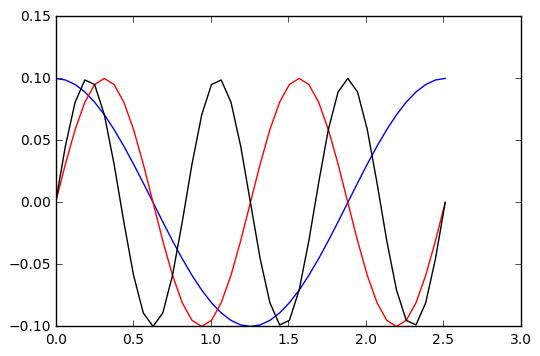

In [9]:
b = 2.5; Lz = 2.*np.pi/b
zArr = np.arange(0., 1.001*Lz, Lz/40.)
plt.plot(zArr, 0.1*np.cos(b*zArr))
plt.plot(zArr, 0.1*np.cos(2.*b*zArr-np.pi/2.),'r')
plt.plot(zArr, 0.1*np.cos(3.*b*zArr-np.pi/2.),'k')
plt.show()

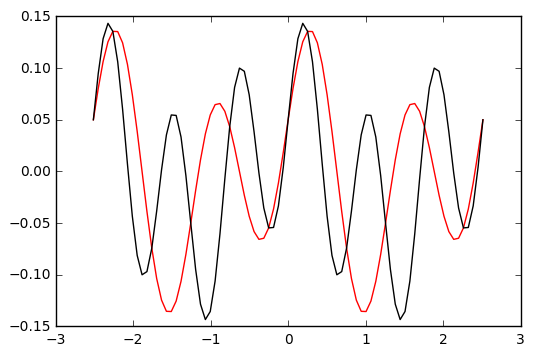

In [11]:
zArr = np.arange(-Lz, 1.001*Lz, Lz/40.)
plt.figure()
plt.plot(zArr, 0.05*np.cos(b*zArr)+0.1*np.cos(2.*b*zArr-np.pi/2.),'r')
plt.plot(zArr, 0.05*np.cos(b*zArr)+0.1*np.cos(3.*b*zArr-np.pi/2.),'k')
plt.show()

## Testing T-derivatives using Fourier Transform

In [16]:
epsArr= np.array([0., 0.05,0.025, 0.03])
Q = epsArr.size-1
phiArr = np.array([0., 0., 1., 0.5])
b = 2.5

Lz = 2.*np.pi/b
zArr = np.arange(0., Lz, Lz/(4*Q+1)).reshape((4*Q+1,1))
qArr = np.arange(-Q, Q+1)
q2Arr = np.arange(-2*Q, 2*Q+1)
epsArrPlus = epsArr # epsArrPlus contains eps_q from q=0 to Q
epsArrFull = np.concatenate((epsArrPlus[:0:-1], epsArrPlus))
phiArrPlus = phiArr # phiArrPlus contains phi_q from q=0 to Q
phiArrFull = np.concatenate((-phiArrPlus[:0:-1], phiArrPlus))
TzSpec = -1.j*b* qArr * epsArrFull * np.exp(-1.j* phiArrFull* np.pi)
TzzSpec = b**2 * qArr**2 * epsArrFull * np.exp(-1.j* phiArrFull * np.pi)
#TzSpec[:] = 0.; TzSpec[Q] = 1.
TzPhys = np.sum( TzSpec.reshape((1,2*Q+1)) * \
                np.exp( 1.j*b*zArr* qArr.reshape((1,2*Q+1))), axis=1)
Tz2Phys = (TzPhys**2).reshape((4*Q+1,1))
q2Arr = q2Arr.reshape((1,4*Q+1))
zArr = zArr.reshape((4*Q+1,1))
Tz2Spec = np.sum( Tz2Phys * \
                 np.exp( -1.j* q2Arr * b * zArr), axis=0)/Tz2Phys.size
#Tz2Spec = np.around(Tz2Spec,decimals=8)

In [17]:
print(TzSpec)
print(TzPhys)
print(Tz2Phys)
print(Tz2Spec)

[ -2.25000000e-01 +1.37772765e-17j  -1.53080850e-17 -1.25000000e-01j
   0.00000000e+00 +1.25000000e-01j   0.00000000e+00 +0.00000000e+00j
   0.00000000e+00 -1.25000000e-01j  -1.53080850e-17 +1.25000000e-01j
  -2.25000000e-01 -1.37772765e-17j]
[-0.45000000 +1.00511317e-19j -0.14380668 +0.00000000e+00j
  0.40891572 -6.93889390e-18j  0.34792050 +0.00000000e+00j
  0.00107951 +0.00000000e+00j  0.15832875 +0.00000000e+00j
  0.51283955 +0.00000000e+00j  0.16082013 +2.77555756e-17j
 -0.66958702 -2.77555756e-17j -0.79798994 +1.38777878e-17j
 -0.02877610 -2.77555756e-17j  0.46493191 +0.00000000e+00j
  0.03532367 +0.00000000e+00j]
[[  2.02500000e-01 -9.04601857e-20j]
 [  2.06803611e-02 -0.00000000e+00j]
 [  1.67212069e-01 -5.67484564e-18j]
 [  1.21048675e-01 +0.00000000e+00j]
 [  1.16534980e-06 +0.00000000e+00j]
 [  2.50679921e-02 +0.00000000e+00j]
 [  2.63004400e-01 +0.00000000e+00j]
 [  2.58631134e-02 +8.92731042e-18j]
 [  4.48346776e-01 +3.71695463e-17j]
 [  6.36787939e-01 -2.21486700e-17j]
 [

In [18]:
flowDict = getDefaultDict()
flowDict.update({'eps':0.1,'epsArr':epsArr,'phiArr':phiArr})
Tz, Tzz, Tz2 = Tderivatives(flowDict)
Tz, Tz2

(array([ -2.25000000e-01 +1.37772765e-17j,
         -1.53080850e-17 -1.25000000e-01j,
          0.00000000e+00 +1.25000000e-01j,
          0.00000000e+00 +0.00000000e+00j,
          0.00000000e+00 -1.25000000e-01j,
         -1.53080850e-17 +1.25000000e-01j,  -2.25000000e-01 -1.37772765e-17j]),
 array([  5.06250000e-02 +2.19300739e-17j,
         -7.68115539e-18 +5.62500000e-02j,
         -1.56250000e-02 -5.62500000e-02j,
          3.12500000e-02 +4.59034520e-17j,
         -1.56250000e-02 +5.62500000e-02j,
         -3.12500000e-02 -5.62500000e-02j,
          1.63750000e-01 +1.52155965e-18j,
         -3.12500000e-02 +5.62500000e-02j,
         -1.56250000e-02 -5.62500000e-02j,
          3.12500000e-02 -4.37684077e-17j,
         -1.56250000e-02 +5.62500000e-02j,
         -7.68115539e-18 -5.62500000e-02j,   5.06250000e-02 -2.19300739e-17j]))

In [19]:
np.abs(Tz2 - Tz2Spec), np.abs(Tzz - TzzSpec)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.]))